# Production / dependence data analysis for May and Nov soil isolates

Updated: 02/02/2023 - ZA


# Table of contents / logic

1. Analyze dependence data by batch
2. Analyze production data by batch
3. Merge dependence and production data and batches to make final calls
4. Generate some figures and sub-lists

### Dependence data: Import and organize dataframes

1. Load packages
2. Function that takes plate reader matrix data and outputs columns with timepoints
3. Organize data into one spreadsheet for each plate (p24, p48)
4. Figure out how to average and plot, etc.

 
\
Code and functions last updated: 220714
\
Updated 221101 to include p168 data

In [1]:
import pandas as pd
from os import listdir
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
#Function to arrange data from multiple plate single reads into columns
def organize_plate_data(directory):
    files = listdir(directory)    # Make list of all files in directory input
    data = pd.DataFrame()    # Make an empty dataframe
    li = []     # Make an empty list
    for f in files:
        if not f.startswith('.'):
            # read the excel file and drop rows with metadata I don't need
            df = pd.read_excel(directory+"/"+f, header=42, skipfooter = 3, index_col=0)
            # Convert matrix to columns and name columns (column 3 is edited to keep just the time and read as integer)
            col_df = df.stack().reset_index().rename(columns={'<>':'Row','level_1':'Column', 0:f[:-5]})
            # append to a list of dataframes
            li.append(col_df)
    # concatenate all dataframes in list into one
    data = pd.concat(li, axis=1)
    # remove duplicated columns and just keep the first instance
    data1 = data.loc[:,~data.T.duplicated(keep='first')]
    # merge row, column into WELL ID and make it the index
    data1.index = data1['Row'] + data1['Column']
    # drop row, column columns cause they're not necessary anymore
    data1.drop(['Row','Column'], axis = 1, inplace = True)
    # Transpose the dataframe and sort the (numeric) index!
    data1 = data1.T.sort_index()
    # VOILA!
    return data1

In [3]:
# Define the directory where I storedd dependence data for each batch 
# Added '/' at the end for the next step to work
may_p24_path = "/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/May21_isolation/may-production-dependence/prod-dep-data/p24_raw/"
may_p48_path = "/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/May21_isolation/may-production-dependence/prod-dep-data/p48_raw/"
may_p168_path = "/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/May21_isolation/may-production-dependence/prod-dep-data/p168_raw/"

nov_p24_path = "/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Nov20_isolation/nov-production-dependence/prod-dep-data/p24_raw/"
nov_p48_path = "/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Nov20_isolation/nov-production-dependence/prod-dep-data/p48_raw/"
nov_p168_path = "/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Nov20_isolation/nov-production-dependence/prod-dep-data/p168_raw/"


In [4]:
# Here, I put data for each plate in its own folder, so I am running
# the function for each plate individually

may_p24_org = organize_plate_data(may_p24_path)
may_p48_org = organize_plate_data(may_p48_path)
may_p168_org = organize_plate_data(may_p168_path)

nov_p24_org = organize_plate_data(nov_p24_path)
nov_p48_org = organize_plate_data(nov_p48_path)
nov_p168_org = organize_plate_data(nov_p168_path)

# p24.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Isolates/May21_isolation/production-dependence/prod-dep-data/p24_data.csv')
# p48.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Isolates/May21_isolation/production-dependence/prod-dep-data/p48_data.csv')
# p168.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Isolates/May21_isolation/production-dependence/prod-dep-data/p168_data.csv')



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
# CONVERT PLATE OUTPUT TO LONGFORM DATA

def make_long(df):
    df1 = df['Timepoint'] = df.index
    df1 = df.melt(id_vars=['Timepoint'], var_name='Well', value_name='A600')
    df1['Row']=df1.Well.str[0]
    df1['Column']=df1.Well.str[1:]

    return df1

In [6]:
# Split up identifier column into new columns for each piece
def name_may_columns(df):
    new = pd.DataFrame()
    new = df["Timepoint"].str.split("_", expand = True)
    
    df['plate'] = new[0]
    df['replicate'] = new[1]
    df['corrinoid'] = new[2]
    df['transfer'] = new[3].str[-1:]
    df['time'] = new[4]
    df['date'] = new[5]
    return df

# Same for november p24
def name_nov_columns1(df):
    new = pd.DataFrame()
    new = df["Timepoint"].str.split("_", expand = True)
    
    df['date'] = new[0]
    df['plate'] = new[1]
    df['replicate'] = new[2]
    df['transfer'] = new[3].str[-1:]
    df['corrinoid'] = new[4]
    df['time'] = new[5]

    return df

# Same for november p48
def name_nov_columns2(df):
    new = pd.DataFrame()
    new = df["Timepoint"].str.split("_", expand = True)
    
    df['plate'] = new[0]
    df['corrinoid'] = new[1]
    df['replicate'] = new[2]
    df['transfer'] = new[3].str[-1:]
    df['time'] = new[4]
    df['date'] = new[5]

    return df

In [7]:
may_p24_long = make_long(may_p24_org)
may_p24_long = name_may_columns(may_p24_long)

may_p48_long = make_long(may_p48_org)
may_p48_long = name_may_columns(may_p48_long)

may_p168_long = make_long(may_p168_org)
may_p168_long = name_may_columns(may_p168_long)

nov_p24_long = make_long(nov_p24_org)
nov_p24_long = name_nov_columns1(nov_p24_long)

nov_p48_long = make_long(nov_p48_org)
nov_p48_long = name_nov_columns2(nov_p48_long)

nov_p168_long = make_long(nov_p168_org)
nov_p168_long = name_nov_columns2(nov_p168_long)

In [8]:
# Import plate layout files

may_p24_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p24_may_layout_dependence.csv')
may_p48_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p48_may_layout_dependence.csv')
may_p168_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p168_may_layout_dependence.csv')
nov_p24_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p24_nov_layout_dependence.csv')
nov_p48_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p48_nov_layout_dependence.csv')
nov_p168_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p168_nov_layout_dependence.csv')

In [9]:
# Rename corrinoid column on layout files so it doesn't clash with the column on data files
may_p24_layout.rename(columns={'Corrinoid':'Isolation corrinoid'}, inplace = True)
may_p48_layout.rename(columns={'Corrinoid':'Isolation corrinoid'}, inplace = True)
may_p168_layout.rename(columns={'Corrinoid':'Isolation corrinoid'}, inplace = True)
nov_p24_layout.rename(columns={'Corrinoid':'Isolation corrinoid'}, inplace = True)
nov_p48_layout.rename(columns={'Corrinoid':'Isolation corrinoid'}, inplace = True)
nov_p168_layout.rename(columns={'Corrinoid':'Isolation corrinoid'}, inplace = True)


In [10]:
# Merge layout and data file on WELL

may_p24 = may_p24_long.merge(may_p24_layout, on='Well')
may_p48 = may_p48_long.merge(may_p48_layout, on='Well')
may_p168 = may_p168_long.merge(may_p168_layout, on='Well')

nov_p24 = nov_p24_long.merge(nov_p24_layout, on='Well')
nov_p48 = nov_p48_long.merge(nov_p48_layout, on='Well')
nov_p168 = nov_p168_long.merge(nov_p168_layout, on='Well')


In [11]:
may_p24

,Timepoint,Well,A600,Row,Column,plate,replicate,corrinoid,transfer,time,date,Plate,Batch,Isolate set,Isolate ID,Organism,Isolation corrinoid
0,p24_r1_cor_transfer1_end_220630,A1,0.1351,A,1,p24,r1,cor,1,end,220630,p24_may,NaN,NaN,WATER,NaN,NaN
1,p24_r1_cor_transfer1_start_220629,A1,0.0991,A,1,p24,r1,cor,1,start,220629,p24_may,NaN,NaN,WATER,NaN,NaN
2,p24_r1_cor_transfer2_end_220701,A1,0.1161,A,1,p24,r1,cor,2,end,220701,p24_may,NaN,NaN,WATER,NaN,NaN
3,p24_r1_cor_transfer2_start_220630,A1,0.1044,A,1,p24,r1,cor,2,start,220630,p24_may,NaN,NaN,WATER,NaN,NaN
4,p24_r1_cor_transfer3_end_220702,A1,0.0970,A,1,p24,r1,cor,3,end,220702,p24_may,NaN,NaN,WATER,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,p24_r3_noc_transfer2_start_220706,H12,0.1595,H,12,p24,r3,noc,2,start,220706,p24_may,NaN,NaN,BLANK,NaN,NaN
4604,p24_r3_noc_transfer3_end_220708,H12,0.1085,H,12,p24,r3,noc,3,end,220708,p24_may,NaN,NaN,BLANK,NaN,NaN
4605,p24_r3_noc_transfer3_start_220707,H12,0.1091,H,12,p24,r3,noc,3,start,220707,p24_may,NaN,NaN,BLANK,NaN,NaN
4606,p24_r3_noc_transfer4_end_220709,H12,0.1135,H,12,p24,r3,noc,4,end,220709,p24_may,NaN,NaN,BLANK,NaN,NaN


### Now I need to do a series of actions to each dataframe:

    1. eliminate water wells,
    2. Check blank wells,
    3. Blank all wells,
    4. get OD from absorbance, (pathlength correction)
    5. determine a growth threshold per plate-replicate duo or per batch ?? try both out

1. drop water

In [12]:
# Drop water rows

may_p24 = may_p24[may_p24['Isolate ID'].str.contains("WATER")==False]
may_p48 = may_p48[may_p48['Isolate ID'].str.contains("WATER")==False]
may_p168 = may_p168[may_p168['Isolate ID'].str.contains("WATER")==False]
nov_p24 = nov_p24[nov_p24['Isolate ID'].str.contains("WATER")==False]
nov_p48 = nov_p48[nov_p48['Isolate ID'].str.contains("WATER")==False]
nov_p168 = nov_p168[nov_p168['Isolate ID'].str.contains("WATER")==False]

In [13]:
# Convert r6 to r2 and r7 to r3 for nov_p48

nov_p48['replicate'] = nov_p48['replicate'].str.replace('r6','r2')
nov_p48['replicate'] = nov_p48['replicate'].str.replace('r7','r3')

2. Check that blank wells are blank!

In [14]:
# This will pull the max blank values for each replicate on a plate (thank u Darryl)
nov_p24[nov_p24['Isolate ID'] == 'BLANK'].groupby('replicate')['A600'].max()

replicate
r1    0.1884
r2    0.2233
r3    0.1927
Name: A600, dtype: float64

In [15]:
nov_p48[nov_p48['Isolate ID']=='BLANK'].groupby('replicate')['A600'].max()

replicate
r1    0.1967
r2    0.1640
r3    0.1563
Name: A600, dtype: float64

In [16]:
nov_p168[nov_p168['Isolate ID']=='BLANK'].groupby('replicate')['A600'].max()

replicate
r1    0.2417
r2    0.2186
r3    0.2251
Name: A600, dtype: float64

In [17]:
may_p24[may_p24['Isolate ID'] == 'BLANK'].groupby('replicate')['A600'].max()

replicate
r1    0.1725
r2    0.1411
r3    0.1632
Name: A600, dtype: float64

In [18]:
may_p48[may_p48['Isolate ID'] == 'BLANK'].groupby('replicate')['A600'].max()

replicate
r1    0.1561
r2    0.1494
r3    0.1350
Name: A600, dtype: float64

In [19]:
may_p168[may_p168['Isolate ID'] == 'BLANK'].groupby('replicate')['A600'].max()

replicate
r1    0.2059
r2    0.1619
r3    0.1631
Name: A600, dtype: float64

## Blank analysis question:
After repeating nov_p48 a couple times, all the blanks look fine and I can continue the analysis.

## Conclusion from blank analysis:
Update: 230314 Repeated p24 r3, and p48 r2 and r3 and replaced data here. 
* p24 looks great now. \
Update: 230427 Repeated p48 (now replicates r6 and r7) and they're not contaminated finally! 
* Data replaced

3. Blank subtraction
4. multiply all wells by the coefficient to get OD600 from absorbance. For 200ul, this coefficient is: 0.5398 For p168, at the start of each transfer there are 200ul and by the end there are closer to 100ul, so I used the coefficient for 100ul: 0.2298

In [20]:
may_p24.reset_index(drop = True, inplace = True)
may_p48.reset_index(drop = True, inplace = True)
may_p168.reset_index(drop = True, inplace = True)
nov_p24.reset_index(drop = True, inplace = True)
nov_p48.reset_index(drop = True, inplace = True)
nov_p168.reset_index(drop = True, inplace = True)

In [21]:
# BLANK SUBTRACTION
# for each dataframe, replicate, and time: average blanks, then subtract blank from all values
df_list = [may_p24, may_p48, may_p168, nov_p24, nov_p48, nov_p168]

for df in df_list:
    df['read_id'] = df['corrinoid']+'_'+df['replicate']+'_'+df['time']+'_'+df['transfer']
read_id = may_p24['read_id'].unique()

for df in df_list:
    for r in read_id:
        avg = df[(df['Isolate ID']=='BLANK')&(df['read_id']==r)]['A600'].mean()
        # need to check what happens in subtraction if avg = nan, it looks like output is fine
        # now subtract
        for row in df.index:
            if df.loc[df.index[row], 'read_id'] == r:
                df.loc[df.index[row], 'Blanked A600'] = df.loc[df.index[row], 'A600'] - avg

/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [22]:
df_fast = [may_p24, may_p48, nov_p24, nov_p48] 
df_slow = [may_p168, nov_p168]

In [23]:
# PATHLENGTH CORRECTION

for df in df_fast:
    for row in df.index:
        df.loc[df.index[row], 'Blanked OD600'] = df.loc[df.index[row],'Blanked A600']/0.5398
    
for df in df_slow:
    for row in df.index:
        if df.loc[df.index[row], 'time'] == 'start':
            df.loc[df.index[row], 'Blanked OD600'] = df.loc[df.index[row],'Blanked A600']/0.5398
        elif df.loc[df.index[row], 'time'] == 'end':
            df.loc[df.index[row], 'Blanked OD600'] = df.loc[df.index[row],'Blanked A600']/0.2298 
# What volume to use - because of evaporation
# Distribution looks the same for p168 and p48 nov so leaving pathlength correction as is above.

In [24]:
# I can drop the blanks now:

may_p24 = may_p24[may_p24['Isolate ID'].str.contains("BLANK")==False]
may_p48 = may_p48[may_p48['Isolate ID'].str.contains("BLANK")==False]
may_p168 = may_p168[may_p168['Isolate ID'].str.contains("BLANK")==False]
nov_p24 = nov_p24[nov_p24['Isolate ID'].str.contains("BLANK")==False]
nov_p48 = nov_p48[nov_p48['Isolate ID'].str.contains("BLANK")==False]
nov_p168 = nov_p168[nov_p168['Isolate ID'].str.contains("BLANK")==False]

### Note
I tested if blank before pathlength = pathlength before blank. It does.

In [25]:
# Before calling dependents, I need to drop the isolates that were inconclusive for May and that I repeated in 
# the november set, from the May dataframes.
# They are in the following lists:

rm_may_p24 = ['2ME_034', '2ME_036_A','2ME_036_B','2ME_037', '5OH_042', '5OH_047', 'ADE_025','ADE_036',
              'B12_042','B12_047','CBI_016_A','CBI_023_A', 'CRE_014*', 'NOC_017', 'NOC_019','NOC_023',
              'NOC_025_B','NOC_026','NOC_030','5OH_031*']
rm_may_p48 = ['2ME_020','2ME_025','2ME_030','2ME_039','5OH_041','5OH_045','5OH_052','B12_045',
             'B12_046','B12_048','B12_056','B12_061','CBI_016_B','CBI_026_A','CBI_030','NOC_014',
             'NOC_015','NOC_031', '2ME_036_C', 'B12_047', 'NOC_030']
rm_may_p168 = ['2ME_012','2ME_040','2ME_041','B12_052','B12_053','CBI_012','CBI_017',
              'NOC_029','NOC_032','5OH_034','NOC_034'] 

In [26]:
may_p24.shape

(3264, 20)

In [27]:
for i in rm_may_p24:
    may_p24.drop(may_p24[may_p24['Isolate ID'] == i].index, inplace = True)
for i in rm_may_p48:
    may_p48.drop(may_p48[may_p48['Isolate ID'] == i].index, inplace = True)
for i in rm_may_p168:
    may_p168.drop(may_p168[may_p168['Isolate ID'] == i].index, inplace = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
# NOC_034 was repeated in the p24_may plate. I am removing the sample in well G7
may_p24 = may_p24[may_p24.Well != 'G7']
may_p24[may_p24['Isolate ID'] == 'NOC_034']
# Same for Well C2 for [5OH_028]
may_p24 = may_p24[may_p24.Well != 'C2']
# I have CBI_016_A and CBI_016_B, so I'm removing CBI_016 because I'm pretty sure it's an annotation error.
may_p168 = may_p168[may_p168['Isolate ID'] != 'CBI_016']


In [29]:
##IGNORE## 
# Assigning growth vs no growth based on threshold.

# may_p24['Growth'] = may_p24['Blanked OD600'].round(4) > may_p24_threshold.round(4)
# may_p48['Growth'] = may_p48['Blanked OD600'].round(4) > may_p48_threshold.round(4)
# may_p168['Growth'] = may_p168['Blanked OD600'].round(4) > may_p168_threshold.round(4)
# nov_p24['Growth'] = nov_p24['Blanked OD600'].round(4) > nov_p24_threshold.round(4)
# nov_p48['Growth'] = nov_p48['Blanked OD600'].round(4) > nov_p48_threshold.round(4)
# # nov_p168_end['Growth'] = nov_p168_end['Blanked OD600'].round(4) > nov_p168_threshold.round(4)

# Set a threshold for growth in corrinoid and eliminate everything that didn't grow in the + cor condition at transfer 4 before proceeding with data analysis.

First, organize all the data:

In [30]:
may_p24_end = may_p24[may_p24['time']=='end'].reset_index(drop = True)
may_p48_end = may_p48[may_p48['time']=='end'].reset_index(drop = True)
may_p168_end = may_p168[may_p168['time']=='end'].reset_index(drop = True)
nov_p24_end = nov_p24[nov_p24['time']=='end'].reset_index(drop = True)
nov_p48_end = nov_p48[nov_p48['time']=='end'].reset_index(drop = True)
nov_p168_end = nov_p168[nov_p168['time']=='end'].reset_index(drop = True)

In [31]:
# make sure all dataframes have the columns in same order
nov_p24 = nov_p24.reindex(columns=may_p24.columns)
nov_p48 = nov_p48.reindex(columns=may_p24.columns)
nov_p168 = nov_p168.reindex(columns=may_p24.columns)
may_p48 = may_p48.reindex(columns=may_p24.columns)
may_p168 = may_p168.reindex(columns=may_p24.columns)

# then concatenate them 
all_data = pd.concat([may_p24,may_p48,may_p168,nov_p24,nov_p48, nov_p168])

# Add some identifiers needed in later steps 
all_data['isolate_row_id'] = all_data['Isolate ID'] + '_' + all_data['Well'] + '_' + all_data['Batch'] + '_'+all_data['replicate']+'_'+all_data['transfer']+'_'+all_data['time']
all_data['isolate_row_id_1'] = all_data['Isolate ID'] + '_' + all_data['Well'] + '_' + all_data['Batch'] + '_'+all_data['replicate']+'_'+'_'+all_data['transfer']

# Subset only end points
all_data_end = all_data[all_data['time']=='end']

In [32]:
# subset dataframes to transfer 4 + cor and transfer 4 - cor
all_t4_end = all_data_end[(all_data_end['transfer']=='4') & (all_data_end['Isolate ID'] != 'Blank')].reset_index(drop = True)
cor_t4_end = all_data_end[(all_data_end['corrinoid']=='cor') & (all_data_end['transfer']=='4') & (all_data_end['Isolate ID'] != 'Blank')].reset_index(drop = True)
noc_t4_end = all_data_end[(all_data_end['corrinoid']=='noc') & (all_data_end['transfer']=='4') & (all_data_end['Isolate ID'] != 'Blank')].reset_index(drop = True)

In [33]:
# Michi's rec: (end od - start od) of plus corrinoid compared to no corrinoid
# to do this:
# take transfer 4 start and end, 
transfer_4 = all_data[all_data['transfer']=='4']
transfer_4 = transfer_4[transfer_4['Isolate ID'].str.contains("Blank")==False]

t4_start = transfer_4[transfer_4['time']=='start']
t4_end = transfer_4[transfer_4['time']=='end']

In [34]:
# merge dataframes ?
merged_t4 = t4_start.merge(t4_end, on=['Well','plate','replicate','corrinoid','transfer',
                                       'Isolate set','Isolate ID'],
                           suffixes=('_start', '_end'))

column_names = ['Timepoint_end', 'Row_end', 'Column_end', 'Plate_end', 'Batch_end', 'Organism_end',
       'Isolation corrinoid_end', 'read_id_end', 'isolate_row_id_end','isolate_row_id_1_end']
merged_t4 = merged_t4.drop(columns=column_names)

merged_t4 = merged_t4.rename(columns={'Timepoint_start': 'Timepoint', 
                                      'Row_start': 'Row',
                                      'Column_start': 'Column', 
                                      'Isolation corrinoid_start': 'Isolation corrinoid',
                                      'Plate_start':'Plate',
                                      'Batch_start':'Batch', 
                                      'Organism_start': 'Organism', 
                                      'Isolation corrinoid_start': 'Isolation corrinoid', 
                                      'read_id_start':'read_id',
                                      'isolate_row_id_start':'isolate_row_id',
                                      'isolate_row_id_1_start':'isolate_row_id_1'
})

merged_t4['delta_OD'] = merged_t4['Blanked OD600_end'] - merged_t4['Blanked OD600_start']
merged_t4



,Timepoint,Well,A600_start,Row,Column,plate,replicate,corrinoid,transfer,time_start,...,Blanked A600_start,Blanked OD600_start,isolate_row_id,isolate_row_id_1,A600_end,time_end,date_end,Blanked A600_end,Blanked OD600_end,delta_OD
0,p24_r1_cor_transfer4_start_220702,B2,0.1042,B,2,p24,r1,cor,4,start,...,0.002450,0.004539,2ME_017_B2_p24_r1_4_start,2ME_017_B2_p24_r1__4,0.2856,end,220703,0.128450,0.237959,0.233420
1,p24_r1_noc_transfer4_start_220702,B2,0.0986,B,2,p24,r1,noc,4,start,...,-0.007250,-0.013431,2ME_017_B2_p24_r1_4_start,2ME_017_B2_p24_r1__4,0.2517,end,220703,0.145950,0.270378,0.283809
2,p24_r2_cor_transfer4_start_220702,B2,0.1051,B,2,p24,r2,cor,4,start,...,0.001900,0.003520,2ME_017_B2_p24_r2_4_start,2ME_017_B2_p24_r2__4,0.2873,end,220703,0.150150,0.278159,0.274639
3,p24_r2_noc_transfer4_start_220702,B2,0.0949,B,2,p24,r2,noc,4,start,...,-0.012750,-0.023620,2ME_017_B2_p24_r2_4_start,2ME_017_B2_p24_r2__4,0.2747,end,220703,0.150400,0.278622,0.302242
4,p24_r3_cor_transfer4_start_220708,B2,0.1044,B,2,p24,r3,cor,4,start,...,-0.012300,-0.022786,2ME_017_B2_p24_r3_4_start,2ME_017_B2_p24_r3__4,0.2825,end,220709,0.163200,0.302334,0.325120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,p168_cor_r2_transfer4_start_220223,E9,0.1074,E,9,p168,r2,cor,4,start,...,-0.003650,-0.006762,5OH_034_E9_p168_r2_4_start,5OH_034_E9_p168_r2__4,0.3157,end,220302,0.161937,0.704689,0.711451
1136,p168_cor_r3_transfer4_start_220223,E9,0.1118,E,9,p168,r3,cor,4,start,...,-0.001400,-0.002594,5OH_034_E9_p168_r3_4_start,5OH_034_E9_p168_r3__4,0.1186,end,220302,0.001937,0.008431,0.011025
1137,p168_noc_r1_transfer4_start_220223,E9,0.1265,E,9,p168,r1,noc,4,start,...,0.002050,0.003798,5OH_034_E9_p168_r1_4_start,5OH_034_E9_p168_r1__4,0.2032,end,220302,-0.008213,-0.035738,-0.039535
1138,p168_noc_r2_transfer4_start_220223,E9,0.1084,E,9,p168,r2,noc,4,start,...,-0.005800,-0.010745,5OH_034_E9_p168_r2_4_start,5OH_034_E9_p168_r2__4,0.1948,end,220302,0.021163,0.092091,0.102836


In [35]:
merged_t4[merged_t4['Isolate ID']=='5OH_041']

,Timepoint,Well,A600_start,Row,Column,plate,replicate,corrinoid,transfer,time_start,...,Blanked A600_start,Blanked OD600_start,isolate_row_id,isolate_row_id_1,A600_end,time_end,date_end,Blanked A600_end,Blanked OD600_end,delta_OD
756,p48_cor_r1_transfer4_start_221011,B7,0.1219,B,7,p48,r1,cor,4,start,...,-0.011200,-0.020748,5OH_041_B7_p48_r1_4_start,5OH_041_B7_p48_r1__4,0.1164,end,221013,-0.002871,-0.005319,0.015429
757,p48_cor_r6_transfer4_start_230413,B7,0.1334,B,7,p48,r2,cor,4,start,...,0.003314,0.006140,5OH_041_B7_p48_r2_4_start,5OH_041_B7_p48_r2__4,0.1353,end,230415,-0.000329,-0.000609,-0.006749
758,p48_cor_r7_transfer4_start_230413,B7,0.1388,B,7,p48,r3,cor,4,start,...,0.011014,0.020404,5OH_041_B7_p48_r3_4_start,5OH_041_B7_p48_r3__4,0.1455,end,230415,-0.000414,-0.000767,-0.021172
759,p48_noc_r1_transfer4_start_221011,B7,0.1827,B,7,p48,r1,noc,4,start,...,-0.002057,-0.003811,5OH_041_B7_p48_r1_4_start,5OH_041_B7_p48_r1__4,0.1486,end,221013,-0.006871,-0.012730,-0.008919
760,p48_noc_r6_transfer4_start_230413,B7,0.1371,B,7,p48,r2,noc,4,start,...,-0.003486,-0.006457,5OH_041_B7_p48_r2_4_start,5OH_041_B7_p48_r2__4,0.1539,end,230415,0.011000,0.020378,0.026835
761,p48_noc_r7_transfer4_start_230413,B7,0.1351,B,7,p48,r3,noc,4,start,...,0.001643,0.003043,5OH_041_B7_p48_r3_4_start,5OH_041_B7_p48_r3__4,0.1475,end,230415,0.000286,0.000529,-0.002514


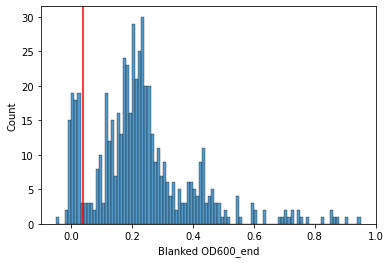

In [36]:
sns.histplot(data = merged_t4[merged_t4['corrinoid']=='cor'], x = 'Blanked OD600_end',
            bins = 100)
plt.axvline(0.04, color = 'red')


In [37]:
cor_growth_thresh = cor_t4_end[cor_t4_end['Blanked OD600']<0.04]
cor_growth_thresh = cor_growth_thresh[cor_growth_thresh['Isolate ID'] != 'BLANK']
cor_growth_thresh
rm_cor_thresh = list(cor_growth_thresh['Isolate ID'].unique())

In [38]:
rm_cor_thresh

['5OH_054_B',
 '5OH_011',
 'ADE_002_A',
 'NOC_010_A',
 '2ME_037',
 '5OH_047',
 'ADE_025',
 'CBI_023_A',
 'NOC_023',
 'NOC_025_B',
 '2ME_020',
 '5OH_041',
 '5OH_052',
 'B12_045',
 'B12_046',
 'B12_047',
 'B12_048',
 'B12_056',
 'CBI_016_A',
 'CBI_026_A',
 'CBI_030',
 'NOC_014',
 '5OH_001',
 '5OH_016_B',
 'B12_035',
 'CRE_003',
 'CRE_009',
 '2ME_036_C',
 '5OH_022',
 'CBI_001',
 'CBI_003',
 'NOC_005',
 '2ME_012',
 '2ME_025',
 'B12_053',
 'CBI_012',
 'CBI_016_B',
 'CBI_017',
 'NOC_029',
 '5OH_034']

In [39]:
for i in rm_cor_thresh:
    merged_t4.drop(merged_t4[merged_t4['Isolate ID'] == i].index, inplace = True)
    cor_t4_end.drop(cor_t4_end[cor_t4_end['Isolate ID'] == i].index, inplace = True)
    noc_t4_end.drop(noc_t4_end[noc_t4_end['Isolate ID'] == i].index, inplace = True)


# Testing out Will's recommended threshold.

There are two possible equations:
((cor)-(noc))/(noc) [simple]

log2[1+((cor - noc)/(noc))]

In [40]:
# ((cor)-(noc))/(noc)
cor_t4_end['will_eq'] = (cor_t4_end['Blanked OD600'] - noc_t4_end['Blanked OD600'])/noc_t4_end['Blanked OD600']


In [41]:
# log2[1+((cor - noc)/(noc))]
# cor_t4_end['will_eq_log'] = math.log2(1+ ((cor_t4_end['Blanked OD600'] - noc_t4_end['Blanked OD600'])/noc_t4_end['Blanked OD600']))


In [42]:
# Trying to make sure I'm subtracting the same things.
cor_t4_end['Blanked OD600 zero'] = [0 if x < 0 else x for x in cor_t4_end['Blanked OD600']]
noc_t4_end['Blanked OD600 zero'] = [0 if x < 0 else x for x in noc_t4_end['Blanked OD600']]

for row in cor_t4_end.index:
    cor_t4_end.loc[row,'will_eq_log'] = math.log2(1+ ((cor_t4_end.loc[row,'A600'] - noc_t4_end.loc[row,'A600'])/noc_t4_end.loc[row,'A600']))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '2ME_017'),
  Text(1, 0, '2ME_021'),
  Text(2, 0, '2ME_022'),
  Text(3, 0, '2ME_024'),
  Text(4, 0, '2ME_027'),
  Text(5, 0, '2ME_029'),
  Text(6, 0, '5OH_024_A'),
  Text(7, 0, '5OH_024_B'),
  Text(8, 0, '5OH_029'),
  Text(9, 0, '5OH_032'),
  Text(10, 0, '5OH_033'),
  Text(11, 0, '5OH_049'),
  Text(12, 0, '5OH_054_A'),
  Text(13, 0, 'ADE_015'),
  Text(14, 0, 'ADE_016'),
  Text(15, 0, 'ADE_021'),
  Text(16, 0, 'ADE_026'),
  Text(17, 0, 'ADE_028'),
  Text(18, 0, 'ADE_030'),
  Text(19, 0, 'ADE_031'),
  Text(20, 0, 'ADE_037'),
  Text(21, 0, 'B12_043'),
  Text(22, 0, 'B12_044'),
  Text(23, 0, 'B12_051'),
  Text(24, 0, 'B12_057'),
  Text(25, 0, 'B12_058'),
  Text(26, 0, 'CBI_013'),
  Text(27, 0, 'CBI_022'),
  Text(28, 0, 'CBI_023'),
  Text(29, 0, 'CBI_029')])

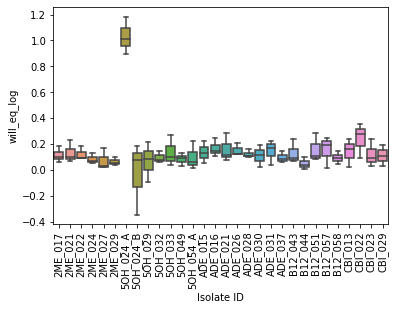

In [43]:
g = sns.boxplot(x = 'Isolate ID', y = 'will_eq_log', data = cor_t4_end[0:89])

plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '2ME_017'),
  Text(1, 0, '2ME_021'),
  Text(2, 0, '2ME_022'),
  Text(3, 0, '2ME_024'),
  Text(4, 0, '2ME_027'),
  Text(5, 0, '2ME_029'),
  Text(6, 0, '5OH_024_A'),
  Text(7, 0, '5OH_024_B'),
  Text(8, 0, '5OH_029'),
  Text(9, 0, '5OH_032'),
  Text(10, 0, '5OH_033'),
  Text(11, 0, '5OH_049'),
  Text(12, 0, '5OH_054_A'),
  Text(13, 0, 'ADE_015'),
  Text(14, 0, 'ADE_016'),
  Text(15, 0, 'ADE_021'),
  Text(16, 0, 'ADE_026'),
  Text(17, 0, 'ADE_028'),
  Text(18, 0, 'ADE_030'),
  Text(19, 0, 'ADE_031'),
  Text(20, 0, 'ADE_037'),
  Text(21, 0, 'B12_043'),
  Text(22, 0, 'B12_044'),
  Text(23, 0, 'B12_051'),
  Text(24, 0, 'B12_057'),
  Text(25, 0, 'B12_058'),
  Text(26, 0, 'CBI_013'),
  Text(27, 0, 'CBI_022'),
  Text(28, 0, 'CBI_023'),
  Text(29, 0, 'CBI_029')])

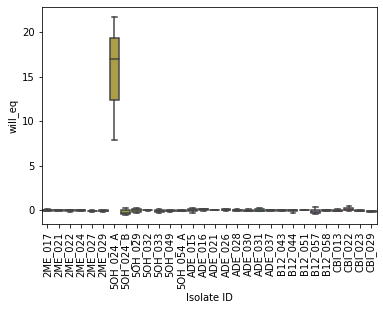

In [44]:
g = sns.boxplot(x = 'Isolate ID', y = 'will_eq', data = cor_t4_end[0:89])

plt.xticks(rotation=90)

In [45]:
control = cor_t4_end[cor_t4_end['Isolation corrinoid']=='NOC']
control['will_eq_log'].max()
control['will_eq_log'].std()

# 230518 - I think the number changed after I filtered out isolates that didn't grow in +cor after 4th transfer.
# Used to be 0.6355, now it is 0.4493

0.253248428844483

In [46]:
0.4493 + (0.2532) # THIS CAN BE MY HIGHER THRESHOLD = 0.7025

0.7024999999999999

In [47]:
positive = cor_t4_end[cor_t4_end['will_eq_log']>0.4493]
positive.shape
pos_plot = list(positive['Isolate ID'].unique())


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '5OH_024_A'),
  Text(1, 0, '5OH_028'),
  Text(2, 0, 'CBI_018'),
  Text(3, 0, 'CRE_019'),
  Text(4, 0, '5OH_039'),
  Text(5, 0, '5OH_040'),
  Text(6, 0, '5OH_043'),
  Text(7, 0, 'B12_063'),
  Text(8, 0, '2ME_018'),
  Text(9, 0, '5OH_036'),
  Text(10, 0, 'B12_064'),
  Text(11, 0, '5OH_005_A'),
  Text(12, 0, 'B12_009'),
  Text(13, 0, 'NOC_007'),
  Text(14, 0, '5OH_042'),
  Text(15, 0, '2ME_036_A'),
  Text(16, 0, '5OH_045'),
  Text(17, 0, 'B12_010'),
  Text(18, 0, 'B12_032'),
  Text(19, 0, 'CRE_008'),
  Text(20, 0, '5OH_017'),
  Text(21, 0, '5OH_020'),
  Text(22, 0, 'B12_004'),
  Text(23, 0, 'CBI_002'),
  Text(24, 0, 'CRE_006')])

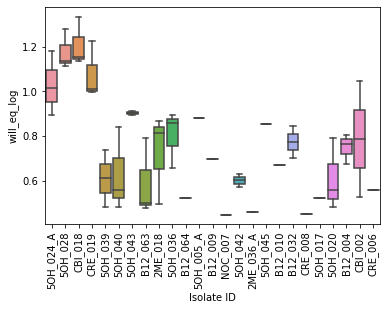

In [48]:
g = sns.boxplot(x = 'Isolate ID', y = 'will_eq_log', data = positive)

plt.xticks(rotation=90)

In [49]:
positive.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/significant_dependent_220427.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, '2ME_021'),
  Text(1, 0, '5OH_029'),
  Text(2, 0, '5OH_033'),
  Text(3, 0, '5OH_054_A'),
  Text(4, 0, 'ADE_015'),
  Text(5, 0, 'ADE_016'),
  Text(6, 0, 'ADE_021'),
  Text(7, 0, 'ADE_026'),
  Text(8, 0, 'ADE_031'),
  Text(9, 0, 'B12_043'),
  Text(10, 0, 'B12_051'),
  Text(11, 0, 'B12_057'),
  Text(12, 0, 'CBI_013'),
  Text(13, 0, 'CBI_022'),
  Text(14, 0, 'CBI_023'),
  Text(15, 0, 'CRE_015'),
  Text(16, 0, 'CRE_016'),
  Text(17, 0, 'NOC_034'),
  Text(18, 0, '5OH_037'),
  Text(19, 0, 'ADE_017'),
  Text(20, 0, '5OH_038'),
  Text(21, 0, 'ADE_020'),
  Text(22, 0, 'B12_062'),
  Text(23, 0, 'CBI_026'),
  Text(24, 0, '5OH_012_A'),
  Text(25, 0, '5OH_012_B'),
  Text(26, 0, '5OH_016_A'),
  Text(27, 0, 'B12_005'),
  Text(28, 0, 'B12_019'),
  Text(29, 0, 'B12_022'),
  Text(30, 0, 'B12_024'),
  

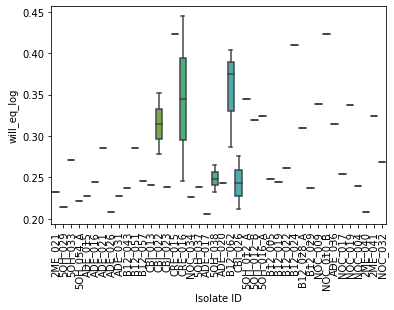

In [50]:
pos_test = cor_t4_end[cor_t4_end['will_eq_log']>0.2]
pos_test = pos_test[~pos_test['Isolate ID'].isin(positive['Isolate ID'])]
pos_test_plot=list(pos_test['Isolate ID'].unique())

g = sns.boxplot(x = 'Isolate ID', y = 'will_eq_log', data = pos_test)

plt.xticks(rotation=90)

In [51]:
# Now I want to confirm these by making a plot for each isolate.
cor_data = all_data_end[all_data_end['corrinoid']=='cor']
noc_data = all_data_end[all_data_end['corrinoid']=='noc']

def plot(isolate):

#     define plotting region (1 rows, 2 columns)
    fig, axes = plt.subplots(1, 2)

    #create boxplot in each subplot
    # No corrinoid
    sns.lineplot(x='transfer', y='Blanked OD600', data=noc_data[noc_data['Isolate ID']==isolate], 
                 hue='replicate', ax = axes[0])
    axes[0].set_ylim(0, 0.6)
    axes[0].set_title('No corrinoid')


    # Corrinoid
    sns.lineplot(x='transfer', y='Blanked OD600', data=cor_data[cor_data['Isolate ID']==isolate], 
                 hue='replicate', ax = axes[1])
    axes[1].set_ylim(0, 0.6)
    axes[1].set_title('Corrinoid')

    fig.suptitle(isolate)


In [52]:
control['will_eq_log'].min()

-0.8102822718091272

In [53]:
negative = cor_t4_end[cor_t4_end['will_eq_log']<-1.1639]
negative
neg_plot = list(negative['Isolate ID'].unique())

(array([0, 1, 2]),
 [Text(0, 0, '2ME_013'), Text(1, 0, 'CRE_018'), Text(2, 0, 'CRE_006')])

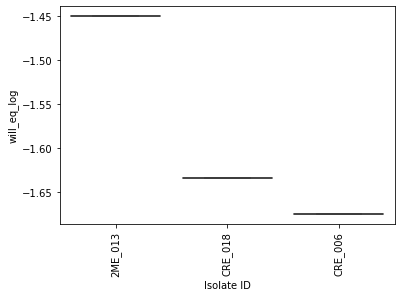

In [54]:
g = sns.boxplot(x = 'Isolate ID', y = 'will_eq_log', data = negative)

plt.xticks(rotation=90)

/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


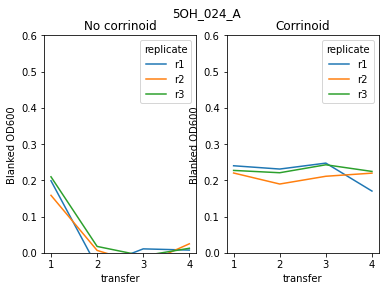

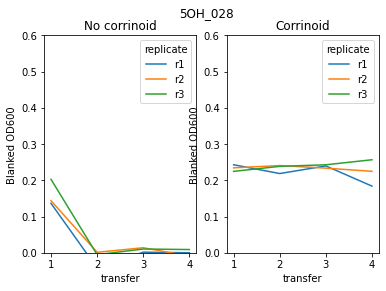

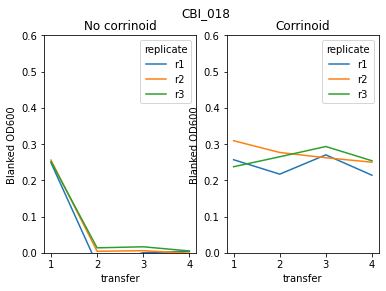

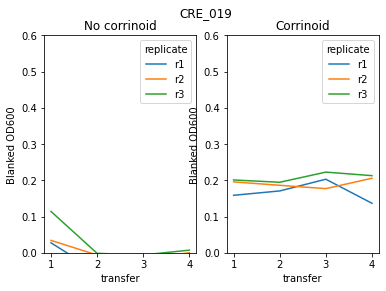

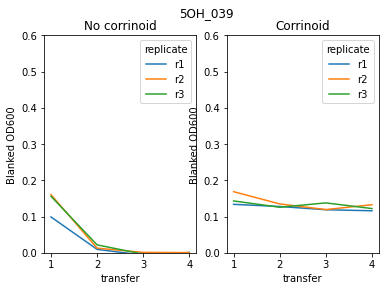

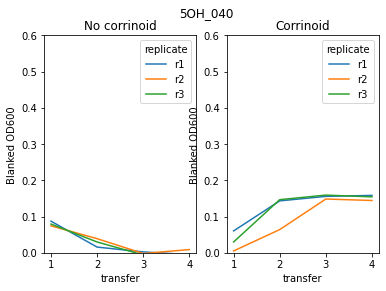

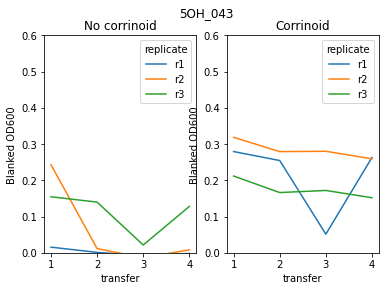

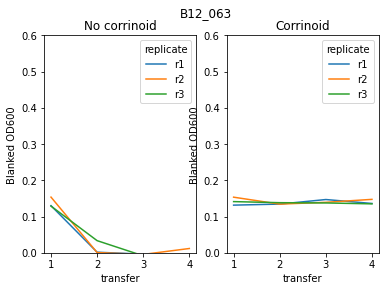

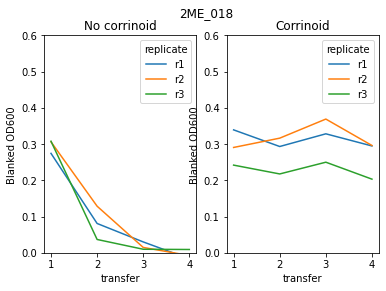

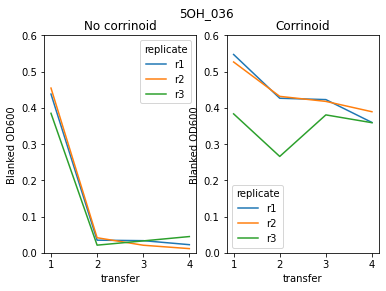

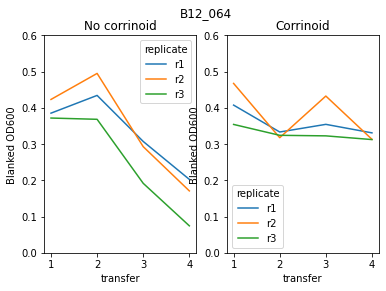

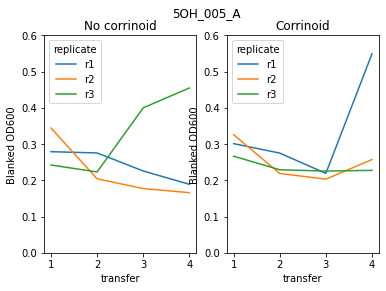

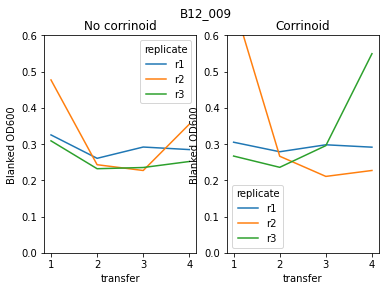

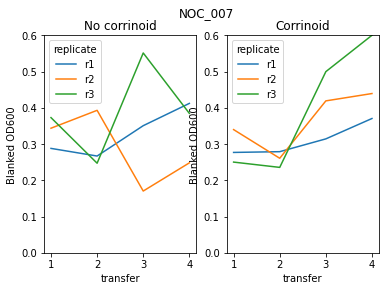

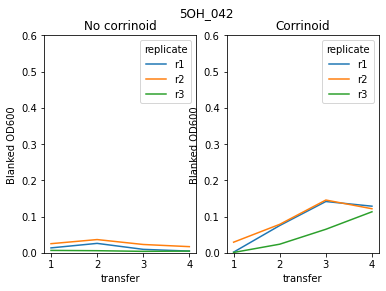

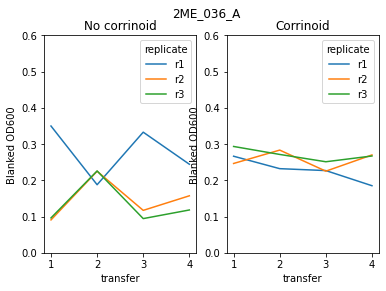

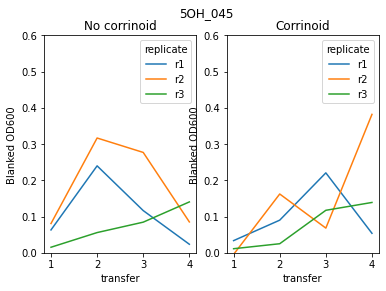

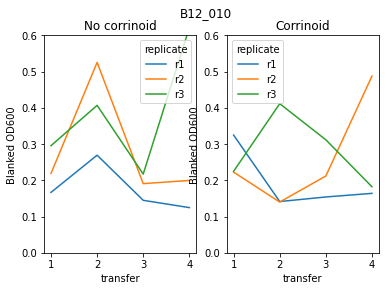

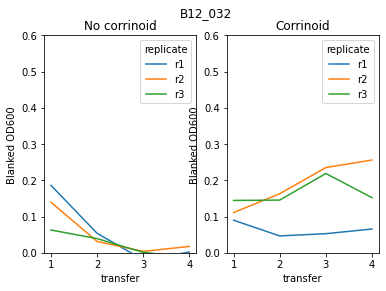

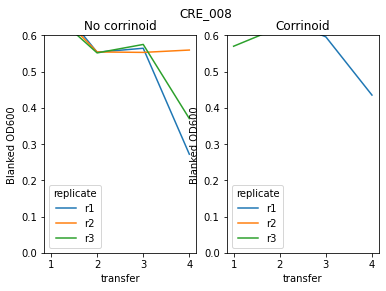

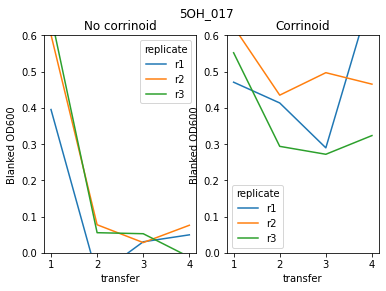

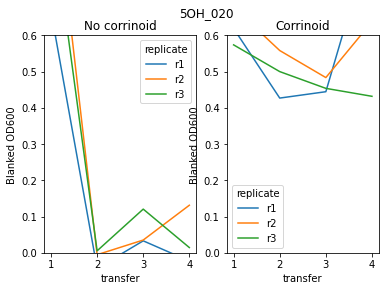

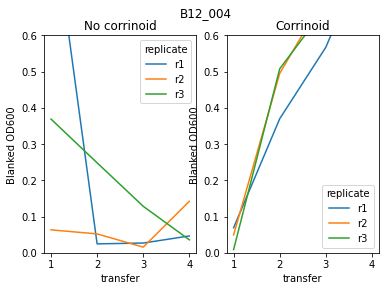

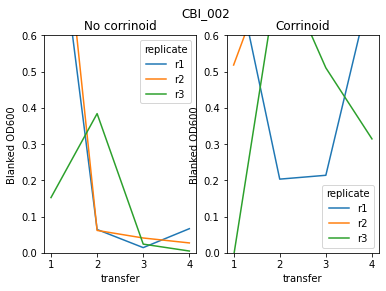

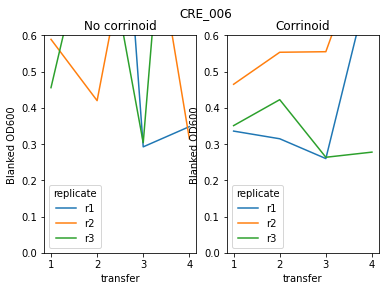

In [55]:
# for id in neg_plot:
#     plot(id)

for id in pos_plot:
    plot(id)

<AxesSubplot:xlabel='Isolate ID', ylabel='will_eq_log'>

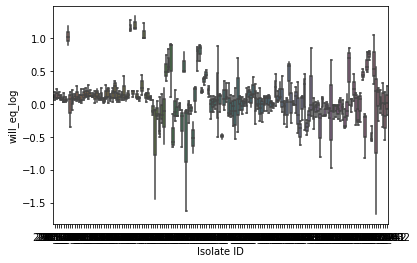

In [56]:
sns.boxplot(x = 'Isolate ID', y = 'will_eq_log', data = cor_t4_end)

<AxesSubplot:xlabel='Isolate ID', ylabel='will_eq'>

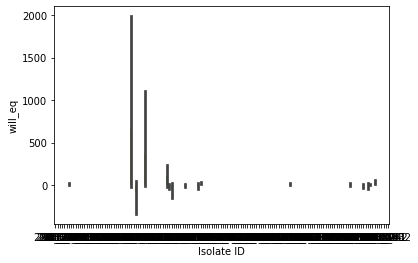

In [57]:
sns.barplot(x = 'Isolate ID', y = 'will_eq', data = cor_t4_end)

In [58]:
merged_t4[merged_t4['Isolate ID'].isin(positive['Isolate ID'])]

,Timepoint,Well,A600_start,Row,Column,plate,replicate,corrinoid,transfer,time_start,...,Blanked A600_start,Blanked OD600_start,isolate_row_id,isolate_row_id_1,A600_end,time_end,date_end,Blanked A600_end,Blanked OD600_end,delta_OD
36,p24_r1_cor_transfer4_start_220702,B12,0.1101,B,12,p24,r1,cor,4,start,...,0.008350,0.015469,5OH_024_A_B12_p24_r1_4_start,5OH_024_A_B12_p24_r1__4,0.2491,end,220703,0.091950,0.170341,0.154872
37,p24_r1_noc_transfer4_start_220702,B12,0.1046,B,12,p24,r1,noc,4,start,...,-0.001250,-0.002316,5OH_024_A_B12_p24_r1_4_start,5OH_024_A_B12_p24_r1__4,0.1098,end,220703,0.004050,0.007503,0.009818
38,p24_r2_cor_transfer4_start_220702,B12,0.1051,B,12,p24,r2,cor,4,start,...,0.001900,0.003520,5OH_024_A_B12_p24_r2_4_start,5OH_024_A_B12_p24_r2__4,0.2558,end,220703,0.118650,0.219804,0.216284
39,p24_r2_noc_transfer4_start_220702,B12,0.1053,B,12,p24,r2,noc,4,start,...,-0.002350,-0.004353,5OH_024_A_B12_p24_r2_4_start,5OH_024_A_B12_p24_r2__4,0.1377,end,220703,0.013400,0.024824,0.029177
40,p24_r3_cor_transfer4_start_220708,B12,0.1036,B,12,p24,r3,cor,4,start,...,-0.013100,-0.024268,5OH_024_A_B12_p24_r3_4_start,5OH_024_A_B12_p24_r3__4,0.2405,end,220709,0.121200,0.224528,0.248796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,p168_cor_r2_transfer4_start_220223,D5,0.1100,D,5,p168,r2,cor,4,start,...,-0.001050,-0.001945,CRE_006_D5_p168_r2_4_start,CRE_006_D5_p168_r2__4,0.3623,end,220302,0.208537,0.907474,0.909419
1052,p168_cor_r3_transfer4_start_220223,D5,0.1052,D,5,p168,r3,cor,4,start,...,-0.008000,-0.014820,CRE_006_D5_p168_r3_4_start,CRE_006_D5_p168_r3__4,0.1805,end,220302,0.063837,0.277796,0.292616
1053,p168_noc_r1_transfer4_start_220223,D5,0.1279,D,5,p168,r1,noc,4,start,...,0.003450,0.006391,CRE_006_D5_p168_r1_4_start,CRE_006_D5_p168_r1__4,0.2914,end,220302,0.079987,0.348074,0.341683
1054,p168_noc_r2_transfer4_start_220223,D5,0.1151,D,5,p168,r2,noc,4,start,...,0.000900,0.001667,CRE_006_D5_p168_r2_4_start,CRE_006_D5_p168_r2__4,0.2460,end,220302,0.072362,0.314893,0.313226


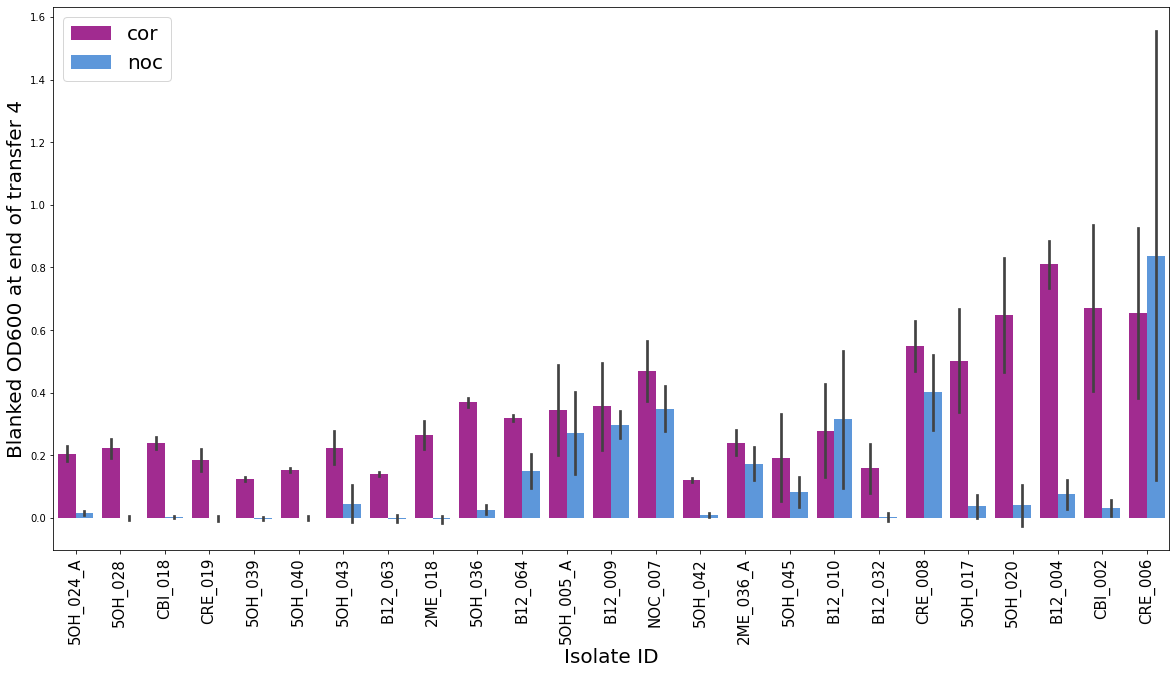

In [59]:
palette = {'cor':'#b5179e', 'noc':'#4895ef'}
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot(x='Isolate ID', y='Blanked OD600_end',  
                data=merged_t4[merged_t4['Isolate ID'].isin(positive['Isolate ID'])],
                hue='corrinoid', ci = 'sd', palette = palette, ax=ax)

plt.xlabel("Isolate ID",fontsize = 20)
plt.ylabel("Blanked OD600 at end of transfer 4",fontsize = 20)
plt.xticks(rotation=90,fontsize = 15)
plt.legend(fontsize = 20)
#     plt.gca().set_ylim(0, 1.5)
#     g.savefig(f"/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/figs1/figure_blankedOD_end_{(iso_corr, batch)}.png")
plt.show()

In [60]:
# cor_t4_end['Dependence status'] = ['Dependent' if x > 0.6355 or 'Possible dependent' if x > 0.4000 & x < 0.6355 else 'Not dependent' for x in cor_t4_end['will_eq_log']]
# 230518 new thresholds!! 0.7025 highest (max no corrinoid result + one std)
# medium: -.4493 (max no corrinoid result)

cor_t4_end['Very likely dependent'] = cor_t4_end['will_eq_log'] > 0.7025
cor_t4_end['Likely dependent'] = cor_t4_end['will_eq_log'].between(0.4493,0.7025, inclusive = True)
cor_t4_end

for row in cor_t4_end.index:
    if cor_t4_end.loc[row, 'Very likely dependent'] == True:
        cor_t4_end.loc[row, 'Dependence classification'] = 'Very likely dependent'
    elif cor_t4_end.loc[row, 'Likely dependent'] == True:
        cor_t4_end.loc[row, 'Dependence classification'] = 'Likely dependent'
    else:
        cor_t4_end.loc[row, 'Dependence classification'] = 'Not dependent'


/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  


<AxesSubplot:xlabel='Isolation corrinoid', ylabel='will_eq_log'>

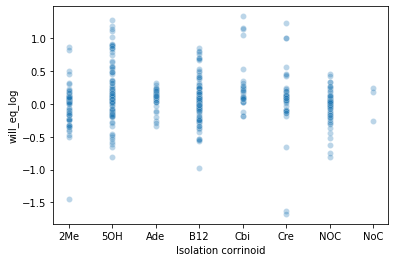

In [61]:
sns.scatterplot(data = cor_t4_end, x = 'Isolation corrinoid', y = 'will_eq_log', alpha = 0.3)

In [62]:
merged_t4.columns

Index(['Timepoint', 'Well', 'A600_start', 'Row', 'Column', 'plate',
       'replicate', 'corrinoid', 'transfer', 'time_start', 'date_start',
       'Plate', 'Batch', 'Isolate set', 'Isolate ID', 'Organism',
       'Isolation corrinoid', 'read_id', 'Blanked A600_start',
       'Blanked OD600_start', 'isolate_row_id', 'isolate_row_id_1', 'A600_end',
       'time_end', 'date_end', 'Blanked A600_end', 'Blanked OD600_end',
       'delta_OD'],
      dtype='object')

In [63]:
cor_t4_end.columns

Index(['Timepoint', 'Well', 'A600', 'Row', 'Column', 'plate', 'replicate',
       'corrinoid', 'transfer', 'time', 'date', 'Plate', 'Batch',
       'Isolate set', 'Isolate ID', 'Organism', 'Isolation corrinoid',
       'read_id', 'Blanked A600', 'Blanked OD600', 'isolate_row_id',
       'isolate_row_id_1', 'will_eq', 'Blanked OD600 zero', 'will_eq_log',
       'Very likely dependent', 'Likely dependent',
       'Dependence classification'],
      dtype='object')

In [64]:
# cor_t4_end.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/cor_t4_end_230519.csv')

In [65]:
dep_summary = cor_t4_end.groupby(['Batch','Isolate ID']).sum()[['Likely dependent', 'Very likely dependent']]
dep_summary
# dep_summary.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/dependence_summary_220518.csv')

Likely dependent  Very likely dependent
Batch Isolate ID                                         
p168  2ME_007                    0                      0
      2ME_008                    0                      0
      2ME_018                    1                      2
      2ME_040                    0                      0
      2ME_041                    0                      0
...                            ...                    ...
p48   NOC_015                    0                      0
      NOC_016                    0                      0
      NOC_028                    0                      0
      NOC_030                    0                      0
      NOC_031                    0                      0

[150 rows x 2 columns]

In [66]:
# means = cor_t4_end.groupby(['Batch','Isolate ID']).mean().reset_index()
# mean_control = control.groupby(['Batch','Isolate ID']).mean()
# means

In [67]:
# mean_control['will_eq_log'].max()

In [68]:
# mean_positive = means[means['will_eq_log']>0.2548]
# mean_positive.shape
# mean_pos_plot = list(mean_positive['Isolate ID'].unique())


In [69]:
# mean_pos = [x for x in cor_t4_end['Isolate ID'] if x in mean_positive]
# mean_pos

In [70]:
# g = sns.boxplot(x = 'Isolate ID', y = 'will_eq_log', data = mean_positive)

# plt.xticks(rotation=90)

In [71]:
# for id in mean_pos_plot:
#     plot(id)

In [72]:
# palette = {'cor':'#b5179e', 'noc':'#4895ef'}
# fig, ax = plt.subplots(figsize=(20,10))

# ax = sns.barplot(x='Isolate ID', y='Blanked OD600_end',  
#                 data=merged_t4[merged_t4['Isolate ID'].isin(mean_positive['Isolate ID'])],
#                 hue='corrinoid', ci = 'sd', palette = palette, ax=ax)

# plt.xlabel("Isolate ID",fontsize = 20)
# plt.ylabel("Blanked OD600 at end of transfer 4",fontsize = 20)
# plt.xticks(rotation=90,fontsize = 15)
# plt.legend(fontsize = 20)
# #     plt.gca().set_ylim(0, 1.5)
# #     g.savefig(f"/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/figs1/figure_blankedOD_end_{(iso_corr, batch)}.png")
# plt.show()

# Exploring different wells

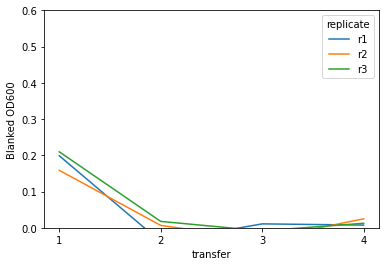

In [73]:
# No corrinoid
sns.lineplot(x='transfer', y='Blanked OD600', data=may_p24_end[(may_p24_end['Well']=='B12') & (may_p24_end['corrinoid']=='noc')], 
             hue='replicate')
plt.gca().set_ylim(0, 0.6)
plt.show()

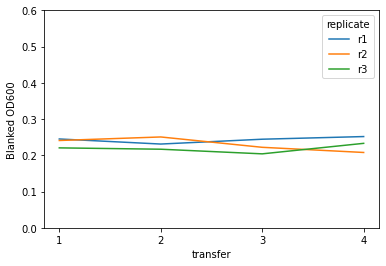

In [74]:
# Corrinoid
sns.lineplot(x='transfer', y='Blanked OD600', data=may_p48_end[(may_p48_end['Well']=='D10') & (may_p48_end['corrinoid']=='cor')], 
             hue='replicate')
plt.gca().set_ylim(0, 0.6)
plt.show()

In [75]:
# may_p24_end[may_p24_end['Well']=='F11']['Isolate ID']

In [76]:
palette = {'cor':'#b5179e', 'noc':'#4895ef'}

## Code below will plot by corrinoid

In [77]:
# combinations1 = [("NOC", "p24", "p48"),
#                 ("2Me", "p24", "p48"),
#                 ("5OH", "p24", "p48"), 
#                 ("Ade", "p24", "p48"), 
#                 ("B12", "p24", "p48"), 
#                 ("Cbi", "p24", "p48"), 
#                 ("Cre", "p24", "p48")]


# # # Loop through each combination and plot the corresponding data
# for i, (iso_corr, batch1, batch2) in enumerate(combinations1):
# #     fig, ax = plt.subplots(figsize=(20,10))

#     g = sns.catplot(data=merged_t4[(merged_t4['Isolation corrinoid']==iso_corr) & ((merged_t4['Batch']==batch1) | (merged_t4['Batch']==batch2))], 
#                 kind="bar",
#                 x='Isolate ID', y='Blanked OD600_end', 
#                 ci = 'sd',
#                 hue= 'corrinoid',  palette=palette,
#                 aspect = 2,
#                 legend=False)
#     g.fig.set_figwidth(15)
#     g.fig.set_figheight(9)
#     plt.xlabel("Isolate ID", fontsize = 15)
#     plt.ylabel("Blanked OD600 at end of transfer 4", fontsize = 15)
#     plt.xticks(rotation=90)
# #     plt.gca().set_ylim(0, 1.5)
#     plt.tick_params(axis='both', which='major', labelsize=15)
#     legend = plt.legend(fontsize=15)
#     plt.tight_layout()
# #     plt.savefig(f"/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/figs1/wide_figure_blankedOD_end_p24p48{iso_corr}.png",)

# # Show the plot
# # plt.show()

In [78]:
# fig, ax = plt.subplots(figsize=(20,10))

# ax = sns.barplot(x='Isolate ID', y='Blanked OD600_end',  
#                 data=merged_t4[(merged_t4['Isolation corrinoid']=='5OH') & ((merged_t4['Batch']=='p24') | (merged_t4['Batch']=='p48'))], 
#                 hue='corrinoid', ci = 'sd', palette = palette, ax=ax)

# plt.xlabel("Isolate ID")
# plt.ylabel("Blanked OD600 at end of transfer 4")
# plt.xticks(rotation=90)
# #     plt.gca().set_ylim(0, 1.5)
# #     g.savefig(f"/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/figs1/figure_blankedOD_end_{(iso_corr, batch)}.png")
# plt.show()

## Calling dependence

In [79]:
# add code here to modify master spreadsheet with dependence calls

# Now for bioassay stuff!

In [80]:
# Import data
bnov_p24_path = '/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Nov20_isolation/nov-production-dependence/prod-dep-data/p24_bioassay'
bnov_p48_path = '/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Nov20_isolation/nov-production-dependence/prod-dep-data/p48_bioassay'
bnov_p168_path = '/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Nov20_isolation/nov-production-dependence/prod-dep-data/p168_bioassay'

bmay_p24_path = '/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/May21_isolation/may-production-dependence/prod-dep-data/p24_bioassay'
bmay_p48_path = '/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/May21_isolation/may-production-dependence/prod-dep-data/p48_bioassay'
bmay_p168_path = '/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/May21_isolation/may-production-dependence/prod-dep-data/p168_bioassay'


In [81]:
bmay_p24 = organize_plate_data(bmay_p24_path)
bmay_p48 = organize_plate_data(bmay_p48_path)
bmay_p168 = organize_plate_data(bmay_p168_path)

bnov_p24 = organize_plate_data(bnov_p24_path)
bnov_p48 = organize_plate_data(bnov_p48_path)
bnov_p168 = organize_plate_data(bnov_p168_path)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [82]:
bmay_p24_long = make_long(bmay_p24)
bmay_p48_long = make_long(bmay_p48)
bmay_p168_long = make_long(bmay_p168)
bnov_p24_long = make_long(bnov_p24)
bnov_p48_long = make_long(bnov_p48)
bnov_p168_long = make_long(bnov_p168)


In [83]:
def name_bioassay_columns(df):
    new = pd.DataFrame()
    new = df["Timepoint"].str.split("_", expand = True)
    
    df['plate'] = new[0]
    df['replicate'] = new[1]
    df['strain'] = new[2]
    df['time'] = new[3]
    df['date'] = new[4]
    return df

In [84]:
# split and name columns
name_bioassay_columns(bmay_p24_long)
name_bioassay_columns(bmay_p48_long)
name_bioassay_columns(bmay_p168_long)

name_bioassay_columns(bnov_p24_long)
name_bioassay_columns(bnov_p48_long)
name_bioassay_columns(bnov_p168_long)


# give them a column to track the batch
bmay_p24_long['batch'] = 'May'
bmay_p48_long['batch'] = 'May'
bmay_p168_long['batch'] = 'May'
bnov_p24_long['batch'] = 'Nov'
bnov_p48_long['batch'] = 'Nov'
bnov_p168_long['batch'] = 'Nov'

In [85]:
# import plate layouts

bmay_p24_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p24_may_layout_production.csv')
bmay_p48_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p48_may_layout_production.csv')
bmay_p168_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p168_may_layout_production.csv')
bnov_p24_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p24_nov_layout_production.csv')
bnov_p48_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p48_nov_layout_production.csv')
bnov_p168_layout = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/p168_nov_layout_production.csv')

In [86]:
# merge with layouts

bmay_p24 = bmay_p24_long.merge(bmay_p24_layout, on='Well')
bmay_p48 = bmay_p48_long.merge(bmay_p48_layout, on='Well')
bmay_p168 = bmay_p168_long.merge(bmay_p168_layout, on='Well')

bnov_p24 = bnov_p24_long.merge(bnov_p24_layout, on='Well')
bnov_p48 = bnov_p48_long.merge(bnov_p48_layout, on='Well')
bnov_p168 = bnov_p168_long.merge(bnov_p168_layout, on='Well')

In [87]:
# split by replicate when necessary: may p48
bmay_p48.loc[bmay_p48['replicate'] == 'r1r2', 'rep'] = bmay_p48['Rep_plate1']
bmay_p48.loc[bmay_p48['replicate'] == 'r3', 'rep'] = bmay_p48['Rep_plate2']

# split by replicate when necessary: may p168
bmay_p168.loc[bmay_p168['replicate'] == 'r1r2r3', 'rep'] = bmay_p168['Rep_plate1']

# for others, assign rep column so I can subset them the same ways:
bmay_p24['rep']=bmay_p24['replicate']
bnov_p24['rep']=bnov_p24['replicate']
bnov_p48['rep']=bnov_p48['replicate']
bnov_p168['rep']=bnov_p168['replicate']


In [88]:
# now drop the replicate and rep_plate1, 2, 3 columns
bdf_list = [bmay_p24,bmay_p48,bmay_p168,bnov_p24,bnov_p48, bnov_p168]

for df in bdf_list:
    df.drop(['Rep_plate1','Rep_plate2','Rep_plate3'], axis = 1, inplace = True)
    df.dropna(subset=['rep'], axis=0, inplace=True)


In [89]:
# drop waters

bmay_p24 = bmay_p24[bmay_p24['Isolate ID'].str.contains("WATER")==False]
bmay_p48 = bmay_p48[bmay_p48['Isolate ID'].str.contains("WATER")==False]
bmay_p168 = bmay_p168[bmay_p168['Isolate ID'].str.contains("WATER")==False]
bnov_p24 = bnov_p24[bnov_p24['Isolate ID'].str.contains("WATER")==False]
bnov_p48 = bnov_p48[bnov_p48['Isolate ID'].str.contains("WATER")==False]
bnov_p168 = bnov_p168[bnov_p168['Isolate ID'].str.contains("WATER")==False]


In [90]:
# drop NOV p48 r4 and r5 because I have 6 and 7

bnov_p48 = bnov_p48[bnov_p48['rep'].str.contains("r4")==False]
bnov_p48 = bnov_p48[bnov_p48['rep'].str.contains("r5")==False]

In [91]:
# Convert r6 to r2 and r7 to r3

bnov_p48['rep'] = bnov_p48['rep'].str.replace('r6','r2')
bnov_p48['rep'] = bnov_p48['rep'].str.replace('r7','r3')

In [92]:
bnov_p48['rep'].unique()

array(['r1', 'r2', 'r3'], dtype=object)

In [93]:
# REMOVE INCONCLUSIVES

for i in rm_may_p24:
    bmay_p24.drop(bmay_p24[bmay_p24['Isolate ID'] == i].index, inplace = True)
for i in rm_may_p48:
    bmay_p48.drop(bmay_p48[bmay_p48['Isolate ID'] == i].index, inplace = True)
for i in rm_may_p168:
    bmay_p168.drop(bmay_p168[bmay_p168['Isolate ID'] == i].index, inplace = True)

In [94]:
bmay_p24 = bmay_p24[bmay_p24.Well != 'G7']
# bmay_p24[bmay_p24['Isolate ID'] == 'NOC_034']
bmay_p24 = bmay_p24[bmay_p24.Well != 'C2']


## Now for some bioassay math...
1. First: pathlength correction
2. Blank all wells first based on blanks plate:
    For every well on each plate (start and end) 
        subtract blank.
        I guess: r1 + start
            
        
        e.g. metE start - blank start 


In [95]:
# pathlength correction
bmay_p24['OD600'] = bmay_p24['A600'] / 0.5398
bmay_p48['OD600'] = bmay_p48['A600'] / 0.5398
bmay_p168['OD600'] = bmay_p168['A600'] / 0.5398
bnov_p24['OD600'] = bnov_p24['A600'] / 0.5398
bnov_p48['OD600'] = bnov_p48['A600'] / 0.5398
bnov_p168['OD600'] = bnov_p168['A600'] / 0.5398

/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is

In [96]:
# give each dataframe a unique index (why?)
def create_id(df):
    df['id'] = df['Well'] + '_' + df['rep'] + '_' + df['batch'] + '_' + df['plate']
    df.set_index('id',inplace = True)

create_id(bmay_p24)
create_id(bmay_p48)
create_id(bmay_p168)
create_id(bnov_p24)
create_id(bnov_p48)
create_id(bnov_p168)


/Users/zoilaalvarez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
bdf_list = ['bmay_p24', 'bmay_p48', 'bmay_p168', 'bnov_p24', 'bnov_p48', 'bnov_p168']
dict_time = {}
for df_name in bdf_list:
    df = globals()[df_name]  # Access the dataframe by name
    dict_time[f"{df_name}_metE_s"] = df[(df.time == 'start') & (df.strain == 'metE')]
    dict_time[f"{df_name}_metEmetH_s"] =  df[(df.time == 'start') & (df.strain == 'metEmetH')]
    dict_time[f"{df_name}_wt_s"] = df[(df.time == 'start') & (df.strain == 'wt')]
    dict_time[f"{df_name}_blanks_s"] = df[(df.time == 'start') & (df.strain == 'blanks')]

    dict_time[f"{df_name}_metE_e"] = df[(df.time == 'end') & (df.strain == 'metE')]
    dict_time[f"{df_name}_metEmetH_e"] = df[(df.time == 'end') & (df.strain == 'metEmetH')]
    dict_time[f"{df_name}_wt_e"] = df[(df.time == 'end') & (df.strain == 'wt')]
    dict_time[f"{df_name}_blanks_e"] = df[(df.time == 'end') & (df.strain == 'blanks')]

In [98]:
list(dict_time.keys())

['bmay_p24_metE_s',
 'bmay_p24_metEmetH_s',
 'bmay_p24_wt_s',
 'bmay_p24_blanks_s',
 'bmay_p24_metE_e',
 'bmay_p24_metEmetH_e',
 'bmay_p24_wt_e',
 'bmay_p24_blanks_e',
 'bmay_p48_metE_s',
 'bmay_p48_metEmetH_s',
 'bmay_p48_wt_s',
 'bmay_p48_blanks_s',
 'bmay_p48_metE_e',
 'bmay_p48_metEmetH_e',
 'bmay_p48_wt_e',
 'bmay_p48_blanks_e',
 'bmay_p168_metE_s',
 'bmay_p168_metEmetH_s',
 'bmay_p168_wt_s',
 'bmay_p168_blanks_s',
 'bmay_p168_metE_e',
 'bmay_p168_metEmetH_e',
 'bmay_p168_wt_e',
 'bmay_p168_blanks_e',
 'bnov_p24_metE_s',
 'bnov_p24_metEmetH_s',
 'bnov_p24_wt_s',
 'bnov_p24_blanks_s',
 'bnov_p24_metE_e',
 'bnov_p24_metEmetH_e',
 'bnov_p24_wt_e',
 'bnov_p24_blanks_e',
 'bnov_p48_metE_s',
 'bnov_p48_metEmetH_s',
 'bnov_p48_wt_s',
 'bnov_p48_blanks_s',
 'bnov_p48_metE_e',
 'bnov_p48_metEmetH_e',
 'bnov_p48_wt_e',
 'bnov_p48_blanks_e',
 'bnov_p168_metE_s',
 'bnov_p168_metEmetH_s',
 'bnov_p168_wt_s',
 'bnov_p168_blanks_s',
 'bnov_p168_metE_e',
 'bnov_p168_metEmetH_e',
 'bnov_p168_wt_e',

In [99]:
# list the dataframes I want to concatenate
metE_s = [dict_time['bmay_p24_metE_s'],dict_time['bmay_p48_metE_s'],dict_time['bmay_p168_metE_s'],
         dict_time['bnov_p24_metE_s'],dict_time['bnov_p48_metE_s'],dict_time['bnov_p168_metE_s']]

metEmetH_s = [dict_time['bmay_p24_metEmetH_s'],dict_time['bmay_p48_metEmetH_s'],dict_time['bmay_p168_metEmetH_s'],
         dict_time['bnov_p24_metEmetH_s'],dict_time['bnov_p48_metEmetH_s'],dict_time['bnov_p168_metEmetH_s']]

wt_s = [dict_time['bmay_p24_wt_s'],dict_time['bmay_p48_wt_s'],dict_time['bmay_p168_wt_s'],
         dict_time['bnov_p24_wt_s'],dict_time['bnov_p48_wt_s'],dict_time['bnov_p168_wt_s']]

blanks_s = [dict_time['bmay_p24_blanks_s'],dict_time['bmay_p48_blanks_s'],dict_time['bmay_p168_blanks_s'],
         dict_time['bnov_p24_blanks_s'],dict_time['bnov_p48_blanks_s'],dict_time['bnov_p168_blanks_s']]

# end 
metE_e = [dict_time['bmay_p24_metE_e'],dict_time['bmay_p48_metE_e'],dict_time['bmay_p168_metE_e'],
         dict_time['bnov_p24_metE_e'],dict_time['bnov_p48_metE_e'],dict_time['bnov_p168_metE_e']]

metEmetH_e = [dict_time['bmay_p24_metEmetH_e'],dict_time['bmay_p48_metEmetH_e'],dict_time['bmay_p168_metEmetH_e'],
         dict_time['bnov_p24_metEmetH_e'],dict_time['bnov_p48_metEmetH_e'],dict_time['bnov_p168_metEmetH_e']]

wt_e = [dict_time['bmay_p24_wt_e'],dict_time['bmay_p48_wt_e'],dict_time['bmay_p168_wt_e'],
         dict_time['bnov_p24_wt_e'],dict_time['bnov_p48_wt_e'],dict_time['bnov_p168_wt_e']]

blanks_e = [dict_time['bmay_p24_blanks_e'],dict_time['bmay_p48_blanks_e'],dict_time['bmay_p168_blanks_e'],
         dict_time['bnov_p24_blanks_e'],dict_time['bnov_p48_blanks_e'],dict_time['bnov_p168_blanks_e']]

In [100]:
# concatenate the start dataframes
metE_df_s = pd.concat(metE_s)
metEmetH_df_s = pd.concat(metEmetH_s)
wt_df_s = pd.concat(wt_s)
blanks_df_s = pd.concat(blanks_s)

# concatenate the end dataframes
metE_df_e = pd.concat(metE_e)
metEmetH_df_e = pd.concat(metEmetH_e)
wt_df_e = pd.concat(wt_e)
blanks_df_e = pd.concat(blanks_e)

# merge start concatenated dataframe with A600 column from end dataframe

metE_df = pd.merge(metE_df_s, metE_df_e['OD600'], on=['id'], how = 'left', suffixes = ('_metE_start', '_metE_end'))
metEmetH_df =pd.merge(metEmetH_df_s, metEmetH_df_e['OD600'], on=['id'], how = 'left', suffixes = ('_metEmetH_start', '_metEmetH_end'))
wt_df =pd.merge(wt_df_s, wt_df_e['OD600'], on=['id'], how = 'left', suffixes = ('_wt_start', '_wt_end'))
blanks_df =pd.merge(blanks_df_s, blanks_df_e['OD600'], on=['id'], how = 'left', suffixes = ('_blanks_start', '_blanks_end'))

# only keep the columns that I want
metE_df.drop(['Timepoint','A600','strain', 'time', 'date'],axis = 1,inplace = True)
metEmetH_df.drop(['Timepoint','Well','A600','Row','Column','plate','strain', 'time', 'date', 'batch', 'Plate'],axis = 1,inplace = True)
wt_df.drop(['Timepoint','Well','A600','Row','Column','plate','strain', 'time', 'date', 'batch', 'Plate'],axis = 1,inplace = True)
blanks_df.drop(['Timepoint','Well','A600','Row','Column','plate','strain', 'time', 'date', 'batch', 'Plate'],axis = 1,inplace = True)

In [101]:
metEmetH_df

,replicate,Isolate ID,rep,OD600_metEmetH_start,OD600_metEmetH_end
id,,,,,
A1_r1_May_p24,r1,MET,r1,0.247870,0.972212
A1_r2_May_p24,r2,MET,r2,0.259911,1.354576
A1_r3_May_p24,r3,MET,r3,0.248240,0.944053
A2_r1_May_p24,r1,MET,r1,0.261393,0.984068
A2_r2_May_p24,r2,MET,r2,0.257318,1.374398
...,...,...,...,...,...
F5_r2_Nov_p168nov,r2,BLANK,r2,0.245647,0.322156
F5_r3_Nov_p168nov,r3,BLANK,r3,0.243979,0.231011
F6_r1_Nov_p168nov,r1,BLANK,r1,0.239163,0.228974


In [102]:
# now merge dataframes to have all the OD600 end and start on the same dataframe! 

bioassay_df = metE_df.merge(metEmetH_df, on = ['id','replicate','Isolate ID','rep'])
bioassay_df = bioassay_df.merge(wt_df, on = ['id','replicate','Isolate ID','rep'])
bioassay_df = bioassay_df.merge(blanks_df, on = ['id','replicate','Isolate ID','rep'])

In [103]:
bioassay_df

,Well,Row,Column,plate,replicate,batch,Plate,Isolate ID,rep,OD600_metE_start,OD600_metE_end,OD600_metEmetH_start,OD600_metEmetH_end,OD600_wt_start,OD600_wt_end,OD600_blanks_start,OD600_blanks_end
id,,,,,,,,,,,,,,,,,
A1_r1_May_p24,A1,A,1,p24,r1,May,p24_may,MET,r1,0.229715,0.971471,0.247870,0.972212,0.257503,1.035383,0.180808,0.176547
A1_r2_May_p24,A1,A,1,p24,r2,May,p24_may,MET,r2,0.256021,1.179140,0.259911,1.354576,0.257503,1.309930,0.188959,0.239348
A1_r3_May_p24,A1,A,1,p24,r3,May,p24_may,MET,r3,0.251019,0.991849,0.248240,0.944053,0.242497,0.964431,0.189329,0.162282
A2_r1_May_p24,A2,A,2,p24,r1,May,p24_may,MET,r1,0.232308,0.975176,0.261393,0.984068,0.262690,1.001112,0.188774,0.185624
A2_r2_May_p24,A2,A,2,p24,r2,May,p24_may,MET,r2,0.249352,1.201186,0.257318,1.374398,0.254539,1.295480,0.194146,0.247870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F5_r2_Nov_p168nov,F5,F,5,p168nov,r2,Nov,p168_nov,BLANK,r2,0.233235,0.328084,0.245647,0.322156,0.249537,1.446091,0.208781,0.180252
F5_r3_Nov_p168nov,F5,F,5,p168nov,r3,Nov,p168_nov,BLANK,r3,0.250648,0.242127,0.243979,0.231011,0.233976,1.486662,0.197110,0.178214
F6_r1_Nov_p168nov,F6,F,6,p168nov,r1,Nov,p168_nov,BLANK,r1,0.230826,0.228603,0.239163,0.228974,0.228233,1.310856,0.194702,0.195443


In [104]:
# blank shit
bioassay_df['OD600_metE_start_blanked'] = bioassay_df['OD600_metE_start'] - bioassay_df['OD600_blanks_start']
bioassay_df['OD600_metE_end_blanked'] = bioassay_df['OD600_metE_end'] - bioassay_df['OD600_blanks_end']
bioassay_df['OD600_metEmetH_start_blanked'] = bioassay_df['OD600_metEmetH_start'] - bioassay_df['OD600_blanks_start']
bioassay_df['OD600_metEmetH_end_blanked'] = bioassay_df['OD600_metEmetH_end'] - bioassay_df['OD600_blanks_end']
bioassay_df['OD600_wt_start_blanked'] = bioassay_df['OD600_wt_start'] - bioassay_df['OD600_blanks_start']
bioassay_df['OD600_wt_end_blanked'] = bioassay_df['OD600_wt_end'] - bioassay_df['OD600_blanks_end']

In [105]:
# end - start
bioassay_df['metE'] = bioassay_df['OD600_metE_end_blanked'] - bioassay_df['OD600_metE_start_blanked']
bioassay_df['metEmetH'] = bioassay_df['OD600_metEmetH_end_blanked'] - bioassay_df['OD600_metEmetH_start_blanked']
bioassay_df['wt'] = bioassay_df['OD600_wt_end_blanked'] - bioassay_df['OD600_wt_start_blanked']


In [106]:
# ratio !! 
bioassay_df['result'] = (bioassay_df['metE'] - bioassay_df['metEmetH']) / bioassay_df['wt']


In [107]:
bioassay_df

,Well,Row,Column,plate,replicate,batch,Plate,Isolate ID,rep,OD600_metE_start,...,OD600_metE_start_blanked,OD600_metE_end_blanked,OD600_metEmetH_start_blanked,OD600_metEmetH_end_blanked,OD600_wt_start_blanked,OD600_wt_end_blanked,metE,metEmetH,wt,result
id,,,,,,,,,,,,,,,,,,,,,
A1_r1_May_p24,A1,A,1,p24,r1,May,p24_may,MET,r1,0.229715,...,0.048907,0.794924,0.067062,0.795665,0.076695,0.858837,0.746017,0.728603,0.782142,0.022264
A1_r2_May_p24,A1,A,1,p24,r2,May,p24_may,MET,r2,0.256021,...,0.067062,0.939793,0.070952,1.115228,0.068544,1.070582,0.872731,1.044276,1.002038,-0.171196
A1_r3_May_p24,A1,A,1,p24,r3,May,p24_may,MET,r3,0.251019,...,0.061690,0.829567,0.058911,0.781771,0.053168,0.802149,0.767877,0.722860,0.748981,0.060104
A2_r1_May_p24,A2,A,2,p24,r1,May,p24_may,MET,r1,0.232308,...,0.043535,0.789552,0.072619,0.798444,0.073916,0.815487,0.746017,0.725824,0.741571,0.027230
A2_r2_May_p24,A2,A,2,p24,r2,May,p24_may,MET,r2,0.249352,...,0.055206,0.953316,0.063172,1.126528,0.060393,1.047610,0.898110,1.063357,0.987217,-0.167386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F5_r2_Nov_p168nov,F5,F,5,p168nov,r2,Nov,p168_nov,BLANK,r2,0.233235,...,0.024454,0.147833,0.036866,0.141904,0.040756,1.265839,0.123379,0.105039,1.225083,0.014971
F5_r3_Nov_p168nov,F5,F,5,p168nov,r3,Nov,p168_nov,BLANK,r3,0.250648,...,0.053538,0.063913,0.046869,0.052797,0.036866,1.308448,0.010374,0.005928,1.271582,0.003497
F6_r1_Nov_p168nov,F6,F,6,p168nov,r1,Nov,p168_nov,BLANK,r1,0.230826,...,0.036124,0.033160,0.044461,0.033531,0.033531,1.115413,-0.002964,-0.010930,1.081882,0.007363


<AxesSubplot:xlabel='Isolate ID', ylabel='result'>

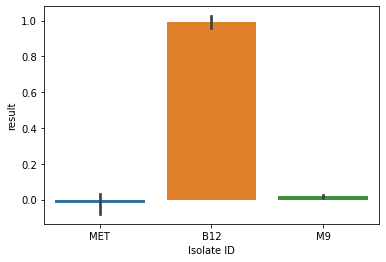

In [108]:
sns.barplot(y = 'result', x = 'Isolate ID', data = bioassay_df[0:30])

Now I need to figure out how to make calls for each isolate and also plot my results! Woot! 

After that I need to integrate everything into master spreadsheet! 

In [109]:
# Set a threshold  
# Call producers and non producers

<AxesSubplot:xlabel='Isolate ID', ylabel='result'>

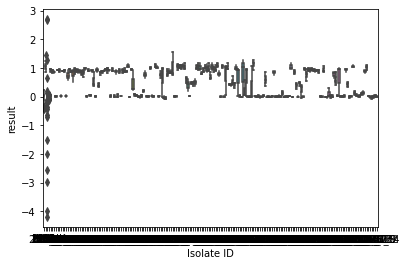

In [110]:
sns.boxplot(y = 'result', x = 'Isolate ID', data = bioassay_df)

In [111]:
# set baseline using Eoin isolates :) 
brodie = pd.read_excel('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Brodie_isolates/Brodie_bioassay_for_baseline_establishment_230504.xlsx')
# brodie

<AxesSubplot:xlabel='conclusion', ylabel='result'>

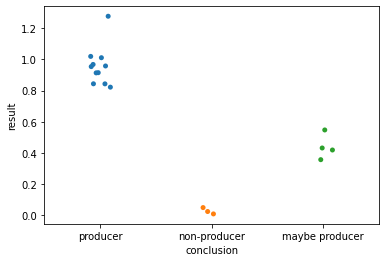

In [112]:
sns.stripplot(x = 'conclusion', y = 'result', data = brodie)

In [113]:
# brodie

In [114]:
brodie[brodie['conclusion'] == 'producer']['result'].min() # 0.82244
brodie[brodie['conclusion'] == 'producer']['result'].max() # 1.2773
brodie[brodie['conclusion'] == 'maybe producer']['result'].min() # 0.35729
brodie[brodie['conclusion'] == 'maybe producer']['result'].max() # 0.54785
brodie[brodie['conclusion'] == 'non-producer']['result'].min() # 0.0092753
brodie[brodie['conclusion'] == 'non-producer']['result'].max() # 0.049956
brodie[brodie['conclusion'] == 'non-producer']['result'].std() # 0.020543
0.049956 + 0.020543

0.070499

Based on Brodie isolates, I will establish the following thresholds:

* non-producer < 0.2
* maybe producer > 0.2 & < 0.6
* producer > 0.6


Reevaluating thresholds:
* non-producer < 0.070499 (non-prod max plus one std)
* maybe producer >= 0.070499 & <= 0.82244
* producer > 0.82244

In [115]:
bioassay_df
bioassay_df.drop(bioassay_df[bioassay_df['Isolate ID'] == 'B12'].index, inplace = True)
bioassay_df.drop(bioassay_df[bioassay_df['Isolate ID'] == 'MET'].index, inplace = True)
bioassay_df.drop(bioassay_df[bioassay_df['Isolate ID'] == 'M9'].index, inplace = True)
bioassay_df.drop(bioassay_df[bioassay_df['Isolate ID'] == 'BLANK'].index, inplace = True)


<AxesSubplot:xlabel='Count', ylabel='result'>

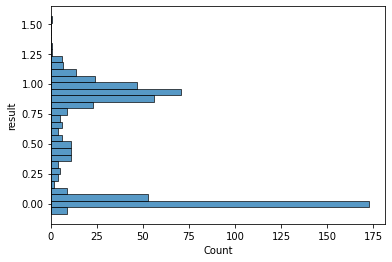

In [116]:
sns.histplot(data = bioassay_df, y = 'result', bins= 30)

In [117]:
# bioassay_df['Producer'] = bioassay_df['result'] > 0.82244
# bioassay_df['Maybe producer'] = bioassay_df['result'].between(0.049956,0.82244, inclusive = True)
# bioassay_df['Non-producer'] = bioassay_df['result'] < 0.049956

# for row in bioassay_df.index:
#     if bioassay_df.loc[row, 'Producer'] == True:
#         bioassay_df.loc[row,'Bioassay conclusion'] = 'Producer'
#     elif bioassay_df.loc[row, 'Maybe producer'] == True:
#         bioassay_df.loc[row,'Bioassay conclusion'] = 'Maybe producer'
#     else: 
#         bioassay_df.loc[row,'Bioassay conclusion'] = 'Non-producer'

# bioassay_df.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/bioassay_conclusions.csv')

In [118]:
bioassay_grouped = bioassay_df.groupby('Isolate ID').sum()
bioassay_grouped.columns
bioassay_grouped.drop(['OD600_metE_start', 'OD600_metE_end', 'OD600_metEmetH_start',
                       'OD600_metEmetH_end', 'OD600_wt_start', 'OD600_wt_end',
                       'OD600_blanks_start', 'OD600_blanks_end', 'OD600_metE_start_blanked',
                       'OD600_metE_end_blanked', 'OD600_metEmetH_start_blanked',
                       'OD600_metEmetH_end_blanked', 'OD600_wt_start_blanked',
                       'OD600_wt_end_blanked', 'metE', 'metEmetH', 'wt', 'result'],
                         axis = 1, inplace = True)
bioassay_grouped.reset_index(inplace = True)
bioassay_grouped.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/bioassay_conclusions1.csv')

In [119]:
bioassay_grouped

,Isolate ID
0,2ME_002_A
1,2ME_004
2,2ME_007
3,2ME_008
4,2ME_010
...,...
186,NOC_030
187,NOC_031
188,NOC_032
189,NOC_034


In [120]:
# sns.barplot(x = 'Isolate ID', y = 'Non-producer', data = bioassay_grouped) 
# Cleaned up so everything has only 3 replicates, and there are no duplicates from repeated inconclusives

## I want to normalize my bioassay data by dividing the result by the final OD600 of t4 no corrinoid in the dependence experiment

In [121]:
# whittle down merged_t4 to just no corrinoid
t4_noc = merged_t4[merged_t4['corrinoid']=='noc'] 
# for merged_t4, I removed isolates for which there was no growth in + corrinoid, that's why it is smaller

In [122]:
# drop blanks
t4_noc = t4_noc[t4_noc['Isolate ID'] != 'BLANK']

In [123]:
# Keep only the columns I need
t4_noc = t4_noc[['Isolate ID', 'replicate', 'Blanked OD600_end']]
t4_noc

,Isolate ID,replicate,Blanked OD600_end
1,2ME_017,r1,0.270378
3,2ME_017,r2,0.278622
5,2ME_017,r3,0.279641
7,2ME_021,r1,0.226843
9,2ME_021,r2,0.228603
...,...,...,...
1096,B12_052,r2,0.312718
1097,B12_052,r3,0.322998
1131,NOC_032,r1,0.215350
1132,NOC_032,r2,0.365807


In [124]:
t4_noc[t4_noc['Isolate ID']=='5OH_041']

,Isolate ID,replicate,Blanked OD600_end


In [125]:
t4_noc['Blanked OD600_end'].min() # Because I removed the + corrinoid negatives but not the no corrinoid negatives.

-0.058595776213412366

In [126]:
# Remove useless 'rep' column and make sure my replicate columns are named the same
bioassay_df.drop('replicate', axis = 1, inplace = True)
bioassay_df.rename(columns = {'rep': 'replicate'}, inplace = True)

In [127]:
bioassay_df.shape

(573, 26)

In [128]:
t4_noc.shape

(450, 3)

In [129]:
# merge t4_noc and bioassay_df on Isolate ID and replicate. Just need: Blanked OD600_end from t4

bioassay_df_merged = bioassay_df.merge(t4_noc, how = 'right', on = ['Isolate ID', 'replicate'])
# IT IS FINALLY CLEAN!!!

In [130]:
bioassay_df_merged.shape

(450, 27)

In [131]:
bioassay_df_merged['Normalized Result'] = bioassay_df_merged['result'] / bioassay_df_merged['Blanked OD600_end']
# bioassay_df_merged.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/bioassay_merge_test_230519.csv')

In [132]:
# bioassay_df_merged

In [133]:
# bio_filtered.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/bioassay_call_test_230519.csv')

# Making final producer/non-producer call based on Michi's recommended flowchart:

If normalized result = NAN: Inconclusive (means no growth in +corrinoid)\
Else:\
If WT didn't grow (WT < 0.5, normal is greater than 1.0): Inconclusive (represses bioassay strain growth)\
Else:\
If metEmetH grew (metEmetH >= 0.5): Inconclusive (too much methionine growth, control bad)\
Else: \
If Normalized Result >= 2: Producer (growth due to corrinoid normalized to OD600 of isolate)\
Else: (normalized result <2)\
If isolate didn't grow much (OD < 0.1): Inconclusive (not enough isolate growth, may be producing very little or not producing)\
Else: (isolate OD > 0.1)\
If metE > 0.1: Producer\
If metE < 0.1: Non Producer\


In [134]:
# Loop to make the calls:
bioassay_df_merged['Final Result'] = 'False'

for r in bioassay_df_merged.index:
    if np.isnan(bioassay_df_merged.at[r, 'Normalized Result']):
        bioassay_df_merged.at[r, 'Final Result'] = 'Inconclusive-no growth in cor'
    else:
        if bioassay_df_merged.at[r,'wt'] < 0.5:
            bioassay_df_merged.at[r, 'Final Result'] = 'Inconclusive-represses bioassay strain growth'
        else:
            if bioassay_df_merged.at[r,'metEmetH'] >= 0.5:
                bioassay_df_merged.at[r, 'Final Result'] = 'Inconclusive-growth due to methionine'
            else:
                if bioassay_df_merged.at[r,'Normalized Result'] >= 2.0:
                    bioassay_df_merged.at[r, 'Final Result'] = 'Producer'
                else:
                    if bioassay_df_merged.at[r,'Blanked OD600_end'] < 0.1:
                        bioassay_df_merged.at[r, 'Final Result'] = 'Inconclusive-low isolate growth'
                    else:
                        if bioassay_df_merged.at[r,'metE'] >= 0.1:
                            bioassay_df_merged.at[r, 'Final Result'] = 'Producer'
                        elif bioassay_df_merged.at[r,'metE'] < 0.1:
                            bioassay_df_merged.at[r, 'Final Result'] = 'Non-producer'

bioassay_df_merged['Final Result'].unique()

array(['Producer', 'Non-producer', 'Inconclusive-low isolate growth',
       'Inconclusive-represses bioassay strain growth'], dtype=object)

In [135]:
bioassay_df_merged['Producer'] = False
bioassay_df_merged['Non-producer'] = False
bioassay_df_merged['Inconclusive'] = False

for r in bioassay_df_merged.index:
    if bioassay_df_merged.at[r, 'Final Result'] == 'Producer':
        bioassay_df_merged.at[r, 'Producer'] = True
    elif bioassay_df_merged.at[r, 'Final Result'] == 'Non-producer':
        bioassay_df_merged.at[r, 'Non-producer'] = True
    else:
        bioassay_df_merged.at[r, 'Inconclusive'] = True





In [136]:
bioassay_df_merged[bioassay_df_merged['Plate']=='p48_nov']

,Well,Row,Column,plate,batch,Plate,Isolate ID,replicate,OD600_metE_start,OD600_metE_end,...,metE,metEmetH,wt,result,Blanked OD600_end,Normalized Result,Final Result,Producer,Non-producer,Inconclusive
333,B3,B,3,p48nov,Nov,p48_nov,2ME_030,r1,0.241200,0.237125,...,0.008707,0.015561,1.293442,-0.005299,0.083417,-0.063528,Inconclusive-low isolate growth,False,False,True
334,B3,B,3,p48nov,Nov,p48_nov,2ME_030,r2,0.284920,0.282142,...,0.024639,0.020748,1.051871,0.003698,0.102260,0.036167,Non-producer,False,True,False
335,B3,B,3,p48nov,Nov,p48_nov,2ME_030,r3,0.290663,0.299741,...,0.026306,-0.002779,1.130789,0.025721,0.098899,0.260072,Inconclusive-low isolate growth,False,False,True
336,B4,B,4,p48nov,Nov,p48_nov,2ME_036_A,r1,0.263431,0.321786,...,0.096147,0.026491,1.305854,0.053341,0.244403,0.218250,Non-producer,False,True,False
337,B4,B,4,p48nov,Nov,p48_nov,2ME_036_A,r2,0.305854,0.303446,...,0.026862,0.015932,1.113375,0.009817,0.157280,0.062417,Non-producer,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,E3,E,3,p48nov,Nov,p48_nov,CBI_004,r2,0.269359,1.305298,...,1.078733,0.007040,1.188588,0.901652,0.134680,6.694798,Producer,True,False,False
401,E3,E,3,p48nov,Nov,p48_nov,CBI_004,r3,0.286958,1.406817,...,1.152649,0.020934,1.297703,0.872091,0.128169,6.804221,Producer,True,False,False
402,E5,E,5,p48nov,Nov,p48_nov,CRE_008,r1,0.281215,0.235458,...,-0.014820,0.037051,1.202112,-0.043150,0.272006,-0.158636,Non-producer,False,True,False
403,E5,E,5,p48nov,Nov,p48_nov,CRE_008,r2,0.297703,0.289181,...,0.018155,0.015932,1.123750,0.001978,0.559466,0.003536,Non-producer,False,True,False


In [137]:
# temp = bioassay_df_merged[(bioassay_df_merged['Plate']=='p24_may')&(bioassay_df_merged['replicate']=='r3')][['Isolate ID','Blanked OD600_end']]
# temp.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/choosing_producers/p24_may_r3_OD600_1.csv')

In [138]:
# bioassay_df_merged.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/bioassay_final_calls_230519.csv')

In [139]:
prod_summary = bioassay_df_merged.groupby(['Isolate ID']).sum()[['Producer', 'Non-producer','Inconclusive']]
prod_summary

,Producer,Non-producer,Inconclusive
Isolate ID,,,
2ME_002_A,3,0,0
2ME_004,0,3,0
2ME_007,0,0,3
2ME_008,3,0,0
2ME_010,0,3,0
...,...,...,...
NOC_030,0,3,0
NOC_031,3,0,0
NOC_032,0,3,0


In [140]:
dep_summary

Likely dependent  Very likely dependent
Batch Isolate ID                                         
p168  2ME_007                    0                      0
      2ME_008                    0                      0
      2ME_018                    1                      2
      2ME_040                    0                      0
      2ME_041                    0                      0
...                            ...                    ...
p48   NOC_015                    0                      0
      NOC_016                    0                      0
      NOC_028                    0                      0
      NOC_030                    0                      0
      NOC_031                    0                      0

[150 rows x 2 columns]

In [141]:
whole_summary = dep_summary.merge(prod_summary, how = 'left', on = 'Isolate ID')


In [142]:
whole_summary['Independent'] = 0
for r in whole_summary.index:
    if (whole_summary.at[r,'Likely dependent'] == 0) and (whole_summary.at[r,'Very likely dependent'] == 0):
        if (whole_summary.at[r,'Non-producer'] > 1) and (whole_summary.at[r,'Producer'] ==0) and (whole_summary.at[r,'Inconclusive'] ==0):
            whole_summary.at[r,'Independent'] = whole_summary.at[r,'Non-producer']

# whole_summary

In [143]:
# whole_summary['Final inconclusive'] = 0
# for r in whole_summary.index:
    

In [144]:
# whole_summary.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/whole_summary_230519.csv')

In [145]:
whole_summary

,Likely dependent,Very likely dependent,Producer,Non-producer,Inconclusive,Independent
Isolate ID,,,,,,
2ME_007,0,0,0,0,3,0
2ME_008,0,0,3,0,0,0
2ME_018,1,2,1,0,2,0
2ME_040,0,0,2,1,0,0
2ME_041,0,0,2,1,0,0
...,...,...,...,...,...,...
NOC_015,0,0,3,0,0,0
NOC_016,0,0,3,0,0,0
NOC_028,0,0,0,3,0,3


# Now to integrate results to the master spreadsheet

In [146]:
# Import spreadsheet
master = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/master_spreadsheet.csv')

# Add dependence and bioassay results summary
master = master.merge(whole_summary, how = 'right', on = 'Isolate ID')
master

# master.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/prod-dep-analysis/master_spreadsheet_with_results_230522.csv')

,Isolate ID_og,Isolate ID,Isolation batch,Medium,Corrinoid,Date stocked,Stocked (Y/N),Freezer location,Notes,Organism_sequencing_consensus,...,Phylum_Match_Sanger_Illumina,Growth curve plate,Growth curve well,Max growth rate,Likely dependent,Very likely dependent,Producer,Non-producer,Inconclusive,Independent
0,HSVL2Me_007,2ME_007,Nov_20,VL55,2Me,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,3,0
1,HSVL2Me_008,2ME_008,Nov_20,VL55,2Me,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,3,0,0,0
2,HSVL2Me_018,2ME_018,May_21,VL55,2Me,220422,Y,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2,1,0,2,0
3,HSVL2Me_040,2ME_040,May_21,VL55,2Me,220309,Y,NaN,NaN,NaN,...,T,NaN,NaN,NaN,0,0,2,1,0,0
4,HSVL2Me_041,2ME_041,May_21,VL55,2Me,220503,Y,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,HSVLNoC_015,NOC_015,May_21,VL55,NoC,220309,Y,NaN,NaN,NaN,...,T,NaN,NaN,NaN,0,0,3,0,0,0
147,HSVLNoC_016,NOC_016,May_21,VL55,NoC,220425,Y,NaN,NaN,NaN,...,T,NaN,NaN,NaN,0,0,3,0,0,0
148,HSVLNoC_028,NOC_028,May_21,VL55,NoC,220309,Y,NaN,Accidentally labeled Cbi p3. D4. check sequenc...,NaN,...,F,NaN,NaN,NaN,0,0,0,3,0,3
149,HSVLNoC_030,NOC_030,May_21,VL55,NoC,220309,Y,NaN,NaN,NaN,...,T,NaN,NaN,NaN,0,0,0,3,0,3


# Pull unique genera and the number of isolates that have results and resolved genera


In [147]:
genus_illumina = list(master['Genus_Illumina'].unique())

In [148]:
genus_sanger = list(master['Genus_Sanger'].unique())

In [149]:
list(master['Phylum_Sanger'].unique())

['Firmicutes', 'Proteobacteria', nan, 'Actinobacteria', 'Bacteroidetes']

In [150]:
list(master['Phylum_Illumina'].unique())

[nan,
 'Actinobacteria',
 'Bacteroidetes',
 'Proteobacteria',
 'Acidobacteria',
 'Firmicutes']

In [151]:
sum(master['Genus_Sanger'].isna())

64

In [152]:
sum(master['Genus_Illumina'].isna())

66

In [153]:
sum(master['Genus_Sanger']=='Unknown')

0

In [154]:
sum(master['Genus_Illumina']=='Unknown')

10

In [155]:
genus_predictions = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/summary_table.csv')

In [156]:
isolate_predictions = genus_predictions[(genus_predictions['Genus'].isin(genus_illumina)) | (genus_predictions['Genus'].isin(genus_sanger))]

# isolate_predictions.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/isolate_prediction_table.csv')

In [157]:
# isolate_predictions # these are percentages

# merge everything

In [158]:
master_ed = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/master_merge_annotated_230529.csv')

In [159]:
# master_ed.rename(columns = {'Genus_Consensus':'Genus'}, inplace = True)
# master_ed['Genus_Consensus']
# master = master_ed.merge(isolate_predictions, on = 'Genus', how = 'outer')


In [160]:
# Did this manually on excel

# master['Conclusion'] = 'False'
# for r in master.index:
#     if master.at[r,'Producer']>=2:
#         master.at[r,'Conclusion'] = 'Producer'
#     elif master.at[r,'Non-producer']==3 and master.at[r,'Independent']==0:
#         master.at[r,'Conclusion'] = 'Non-producer'
#     elif master.at[r,'Independent']==3:
#         master.at[r,'Conclusion'] = 'Independent'
#     elif master.at[r,'Likely dependent'] + master.at[r,'Very likely dependent']==3:
#         master.at[r,'Conclusion'] = 'Dependent*'
#     else:
#         master.at[r,'Conclusion'] = 'Inconclusive'
# master

In [161]:
master_ed['Conclusion_manual'].value_counts()

Producer        96
Independent     22
Inconclusive    15
Dependent       12
Dependent*       6
Name: Conclusion_manual, dtype: int64

In [162]:
master_ed.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Isolate ID_og', 'Isolate ID',
       'Isolation batch', 'Medium', 'Corrinoid', 'Date stocked',
       'Stocked (Y/N)', 'Freezer location', 'Notes',
       'Organism_sequencing_consensus', 'Illumina name index', 'Illumina ID',
       'Illumina Zotu', 'Phylum_Illumina', 'Class_Illumina', 'Order_Illumina',
       'Family_Illumina', 'Genus_Illumina', 'Successfully Sanger sequenced',
       'Sanger plate', 'Sanger assembly', '%GC_Sanger', '%HQ_Sanger',
       'Organism ID_Sanger', 'Accession ID for top Sanger hit',
       'Pairwise ID_Sanger', 'Query cover_Sanger', 'Potentially novel',
       'Possible contaminant (T/F)', 'Phylum_Sanger', 'Class_Sanger',
       'Order_Sanger', 'Family_Sanger', 'Genus_Sanger', 'Species_Sanger',
       'Phylum_Match_Sanger_Illumina', 'Growth curve plate',
       'Growth curve well', 'Max growth rate', 'Likely dependent',
       'Very likely dependent', 'Producer', 'Non-producer', 'Inconclusive',
       'Independent', 'Gen

# Making summary of results table

In [163]:
genus_predictions = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/genus_summary_230427.csv')

In [164]:
genus_predictions = genus_predictions[genus_predictions['total # of species']>=3]

In [165]:
g = genus_predictions[(genus_predictions['% corrinoid producer']>=95)|(genus_predictions['% corrinoid dependent']>=95)|(genus_predictions['% corrinoid independent']>=95)|(genus_predictions['% corrinoid producer']<=5)|(genus_predictions['% corrinoid dependent']<=5)|(genus_predictions['% corrinoid independent']<=5)]
g

,Unnamed: 0,Genus,Phylum,total # of species,tetrapyrrole precursor salvager,Cbi salvager,corrinoid precursor salvager,corrinoid producer,corrinoid non-producer,corrinoid independent,...,% corrinoid producer,% corrinoid non-producer,% corrinoid independent,% corrinoid user,% not corrinoid user,% corrinoid dependent and independent,% obligate corrinoid user,% not obligate corrinoid user,% corrinoid precursor salvager,% corrinoid dependent
6,6,Acetobacter,Proteobacteria,12,0,0,0,12,0,0,...,100.000000,0.000000,0.000000,100.000000,0.000000,91.666667,8.333333,91.666667,0.000000,0.000000
7,7,Acetobacterium,Firmicutes,3,0,0,0,3,0,0,...,100.000000,0.000000,0.000000,100.000000,0.000000,100.000000,100.000000,0.000000,0.000000,0.000000
11,11,Acholeplasma,Tenericutes,11,0,0,0,0,11,9,...,0.000000,100.000000,81.818182,18.181818,81.818182,9.090909,9.090909,9.090909,0.000000,18.181818
12,12,Achromobacter,Proteobacteria,40,0,0,0,0,40,0,...,0.000000,100.000000,0.000000,100.000000,0.000000,97.500000,0.000000,100.000000,0.000000,100.000000
14,14,Acidaminococcus,Firmicutes,6,0,0,0,0,6,0,...,0.000000,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1561,Winogradskyella,Bacteroidetes,5,0,0,0,0,5,0,...,0.000000,100.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000
1562,1562,Wolbachia,Proteobacteria,5,0,0,0,0,5,5,...,0.000000,100.000000,100.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1565,1565,Xanthobacter,Proteobacteria,3,0,0,0,3,0,0,...,100.000000,0.000000,0.000000,100.000000,0.000000,100.000000,66.666667,33.333333,0.000000,0.000000
1566,1566,Xanthomonas,Proteobacteria,31,0,13,13,0,18,0,...,0.000000,58.064516,0.000000,100.000000,0.000000,100.000000,3.225806,96.774194,41.935484,100.000000


In [166]:
g = g.groupby(['Genus','Phylum']).sum()[['total # of species', 'corrinoid producer', 'corrinoid dependent', 'corrinoid independent']]
g

,,total # of species,corrinoid producer,corrinoid dependent,corrinoid independent
Genus,Phylum,,,,
Acetobacter,Proteobacteria,12,12,0,0
Acetobacterium,Firmicutes,3,3,0,0
Acholeplasma,Tenericutes,11,0,2,9
Achromobacter,Proteobacteria,40,0,40,0
Acidaminococcus,Firmicutes,6,0,6,0
...,...,...,...,...,...
Winogradskyella,Bacteroidetes,5,0,5,0
Wolbachia,Proteobacteria,5,0,0,5
Xanthobacter,Proteobacteria,3,3,0,0


In [167]:
master_ed = master_ed[master_ed['Conclusion_manual']!='Inconclusive']
master_ed.dropna(subset=['Conclusion_manual'],inplace = True)

master_ed = master_ed[['Phylum_Sanger','Genus','Conclusion_manual']]
master_ed.reset_index(inplace = True, drop = True)
master_ed

,Phylum_Sanger,Genus,Conclusion_manual
0,Actinobacteria,Arthrobacter,Independent
1,Actinobacteria,Arthrobacter,Independent
2,Actinobacteria,Arthrobacter,Independent
3,Actinobacteria,Arthrobacter,Independent
4,NaN,Arthrobacter,Producer
...,...,...,...
131,Proteobacteria,Stenotrophomonas,Producer
132,Proteobacteria,Variovorax,Independent
133,NaN,Unknown,Producer
134,NaN,Unknown,Independent


In [168]:
master_ed['Producer'] = False
master_ed['Dependent'] = False
master_ed['Dependent*'] = False
master_ed['Independent'] = False

for r in master_ed.index:
    if master_ed.at[r,'Conclusion_manual']=='Producer':
        master_ed.at[r,'Producer'] = True
    elif master_ed.at[r,'Conclusion_manual']=='Dependent':
        master_ed.at[r,'Dependent'] = True
    elif master_ed.at[r,'Conclusion_manual']=='Dependent*':
        master_ed.at[r,'Dependent*'] = True
    elif master_ed.at[r,'Conclusion_manual']=='Independent':
        master_ed.at[r,'Independent'] = True

In [169]:
master_grouped = master_ed.groupby(['Phylum_Sanger','Genus']).sum()
master_grouped['total number of isolates'] = master_grouped.sum(axis=1)
# master_grouped
master_grouped = master_grouped.merge(g, on='Genus', how = 'left')
master_grouped
# master_grouped.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/prediction-conclusion_230529.csv')

,Producer,Dependent,Dependent*,Independent,total number of isolates,total # of species,corrinoid producer,corrinoid dependent,corrinoid independent
Genus,,,,,,,,,
Arthrobacter,0,0,0,4,4,85.0,0.0,27.0,58.0
Blastococcus,0,2,0,0,2,9.0,9.0,0.0,0.0
Cellulomonas,0,0,0,1,1,21.0,0.0,4.0,17.0
Knoellia,0,2,0,0,2,5.0,2.0,3.0,0.0
Marmoricola,1,1,0,0,2,3.0,3.0,0.0,0.0
Mycolicibacterium,1,0,0,0,1,NaN,NaN,NaN,NaN
Nocardioides,2,1,0,0,3,36.0,28.0,8.0,0.0
Pseudarthrobacter,1,0,0,3,4,NaN,NaN,NaN,NaN
Mucilaginibacter,0,0,0,1,1,14.0,0.0,14.0,0.0


In [170]:
# master
# summ_conclusive = summ[summ['corrinoid producer'].isna()==False]
# summ_conclusive.to_csv(('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/prediction-conclusion_conclusive15_230527.csv'))


# optional plotting

In [171]:
# cor24 = p24_long[p24_long['corrinoid']=='cor']
# cor24_end = cor24[cor24['time']=='end']
# noc24 = p24_long[p24_long['corrinoid']=='noc']
# noc24_end = noc24[noc24['time']=='end']

# cor48 = p48_long[p48_long['corrinoid']=='cor']
# cor48_end = cor48[cor48['time']=='end']
# noc48 = p48_long[p48_long['corrinoid']=='noc']
# noc48_end = noc48[noc48['time']=='end']

# cor168 = p168_long[p168_long['corrinoid']=='cor']
# cor168_end = cor168[cor168['time']=='end']
# noc168 = p168_long[p168_long['corrinoid']=='noc']
# noc168_end = noc168[noc168['time']=='end']

In [172]:
# sns.set(font_scale=2)
# sns.set_style('white')

In [173]:
# g = sns.FacetGrid(noc24_end, row="Row", col="Column", margin_titles=True)
# g.map_dataframe(sns.scatterplot, "transfer", "A600", hue = "replicate")
# g.add_legend()

In [174]:
# g = sns.FacetGrid(cor24_end, row="Row", col="Column", margin_titles=True)
# g.map_dataframe(sns.scatterplot, "transfer", "A600", hue = "replicate")
# g.add_legend()

In [175]:
# g = sns.FacetGrid(noc48_end, row="Row", col="Column", margin_titles=True)
# g.map_dataframe(sns.scatterplot, "transfer", "A600", hue = "replicate")
# g.add_legend()

In [176]:
# g = sns.FacetGrid(cor48_end, row="Row", col="Column", margin_titles=True)
# g.map_dataframe(sns.scatterplot, "transfer", "A600", hue = "replicate")
# g.add_legend()

In [177]:
# g = sns.FacetGrid(noc168_end, row="Row", col="Column", margin_titles=True)
# g.map_dataframe(sns.scatterplot, "transfer", "A600", hue = "replicate")
# g.add_legend()

In [178]:
# g = sns.FacetGrid(cor168_end, row="Row", col="Column", margin_titles=True)
# g.map_dataframe(sns.scatterplot, "transfer", "A600", hue = "replicate")
# g.add_legend()

# master spreadsheet stuff

In [179]:
#master = pd.read_excel('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/Soil_Isolates/Master spreadsheet with all the info from all the isolates (upd 221111).xlsx')

In [180]:
# new_header = master.iloc[0] #grab the first row for the header
# master = master[1:] #take the data less the header row
# master.columns = new_header #set the header row as the df header

In [181]:
# master.columns

In [182]:
# master.shape

In [183]:
# master = master[master['Possible contaminant (T/F)'].str.contains("Y")==False]

# master['Genus Sanger'].count()

In [184]:
# master_stocked = master[master['Stocked (Y/N)'].str.contains("N")==False]

# master_stocked['Genus Sanger'].count()